# Projet Data Mining : Bank Churn Prediction - Kaggle Competition</span>

# <span style="color:lightblue;">Importation des librairies</span>

In [3]:
import joblib
import lightgbm as lgb
import matplotlib.pyplot as plt
import numpy as np
import optuna
import os
import pandas as pd
import seaborn as sns
import warnings
import xgboost as xgb
from catboost import CatBoostClassifier
from itertools import product
from lightgbm import LGBMClassifier
from scipy.stats import anderson, chi2_contingency, spearmanr
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import auc, classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from itertools import combinations, product

In [2]:
# Pour supprimer les warnings
warnings.filterwarnings("ignore", category=UserWarning, module="lightgbm")
warnings.filterwarnings("ignore", category=FutureWarning, module="sklearn.utils.deprecation")


# <span style="color:lightblue;">Importation des bases de données</span>

In [4]:
data = pd.read_csv("../data/train.csv")
test = pd.read_csv("../data/test.csv")

In [5]:
data

,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,0,15713774.0,Hsieh,683.0,Germany,Male,49.0,7.0,123837.86,2.0,1.0,1.0,138700.75,1.0
1,1,15682533.0,Hs?eh,608.0,France,Female,30.0,10.0,0.00,2.0,1.0,1.0,146723.72,0.0
2,2,15791550.0,Tsou,539.0,France,Female,32.0,8.0,0.00,1.0,1.0,1.0,94873.60,0.0
3,3,15762762.0,Chiawuotu,530.0,Spain,Female,39.0,8.0,0.00,2.0,0.0,0.0,177896.93,0.0
4,4,15756475.0,Nnamdi,613.0,France,Female,45.0,10.0,0.00,2.0,1.0,1.0,116748.14,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14995,14995,15660608.0,Ch'in,681.0,Spain,Male,31.0,1.0,0.00,2.0,1.0,1.0,125445.80,0.0
14996,14996,15767432.0,Fan,549.0,Germany,Male,34.0,7.0,134464.58,1.0,1.0,0.0,126535.92,0.0
14997,14997,15766896.0,Trevisano,550.0,France,Female,46.0,5.0,0.00,2.0,1.0,1.0,133897.32,0.0
14998,14998,15705412.0,Udegbulam,647.0,France,Female,25.0,4.0,141616.55,2.0,1.0,0.0,187597.98,0.0


In [6]:
test

,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
0,15000,15797736.0,Chikwendu,591.0,Germany,Female,32.0,2.0,106881.50,2.0,1.0,0.0,122810.53
1,15001,15676515.0,Lai,553.0,Spain,Male,37.0,2.0,0.00,2.0,1.0,0.0,63736.17
2,15002,15701291.0,Folliero,646.0,France,Female,29.0,7.0,0.00,2.0,1.0,0.0,121866.87
3,15003,15594812.0,Trevisani,603.0,Germany,Male,49.0,8.0,131394.56,1.0,0.0,1.0,147059.28
4,15004,15791321.0,Ch'ien,645.0,Spain,Female,39.0,3.0,0.00,2.0,1.0,0.0,129975.94
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,24995,15642063.0,Tung,694.0,Spain,Male,41.0,6.0,0.00,2.0,0.0,0.0,171378.77
9996,24996,15731267.0,Hsiao,614.0,France,Female,55.0,8.0,157597.61,1.0,1.0,0.0,70974.13
9997,24997,15673367.0,Manna,589.0,France,Male,41.0,4.0,0.00,2.0,1.0,1.0,123475.88
9998,24998,15626141.0,Chukwumaobim,543.0,Germany,Male,33.0,2.0,151659.52,1.0,1.0,1.0,86911.49



# <span style="color:lightblue;">Analyse exploratoire des données</span>

### Analyse des valeurs manquantes et types de données

In [7]:
print("\nInformations générales sur le dataset:")
data.info()


Informations générales sur le dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id               15000 non-null  int64  
 1   CustomerId       15000 non-null  float64
 2   Surname          15000 non-null  object 
 3   CreditScore      15000 non-null  float64
 4   Geography        15000 non-null  object 
 5   Gender           15000 non-null  object 
 6   Age              15000 non-null  float64
 7   Tenure           15000 non-null  float64
 8   Balance          15000 non-null  float64
 9   NumOfProducts    15000 non-null  float64
 10  HasCrCard        15000 non-null  float64
 11  IsActiveMember   15000 non-null  float64
 12  EstimatedSalary  15000 non-null  float64
 13  Exited           15000 non-null  float64
dtypes: float64(10), int64(1), object(3)
memory usage: 1.6+ MB


Il n'y a pas de valeurs manquantes dans le dataset

In [8]:
print("\nInformations générales sur test :")
test.info()


Informations générales sur test :
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id               10000 non-null  int64  
 1   CustomerId       10000 non-null  float64
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  float64
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  float64
 7   Tenure           10000 non-null  float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  float64
 10  HasCrCard        10000 non-null  float64
 11  IsActiveMember   10000 non-null  float64
 12  EstimatedSalary  10000 non-null  float64
dtypes: float64(9), int64(1), object(3)
memory usage: 1015.8+ KB


### Analyse des valeurs aberrantes

In [9]:
data.describe(include = 'all')

,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,15000.000000,1.500000e+04,15000,15000.000000,15000,15000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000
unique,NaN,NaN,755,NaN,3,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,NaN,Ch'iu,NaN,France,Male,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,NaN,311,NaN,9048,8422,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,7499.500000,1.570073e+07,NaN,658.701800,NaN,NaN,37.660800,5.038800,42888.826095,1.589467,0.779800,0.497867,117892.175400,0.199333
std,4330.271354,1.162730e+06,NaN,80.238346,NaN,NaN,8.106408,2.810354,59695.877791,0.532430,0.414395,0.500012,45574.462515,0.399512
min,0.000000,1.557151e+05,NaN,431.000000,NaN,NaN,18.000000,0.000000,0.000000,1.000000,0.000000,0.000000,11.580000,0.000000
25%,3749.750000,1.563387e+07,NaN,602.000000,NaN,NaN,32.000000,3.000000,0.000000,1.000000,1.000000,0.000000,82870.750000,0.000000
50%,7499.500000,1.569018e+07,NaN,661.000000,NaN,NaN,37.000000,5.000000,0.000000,2.000000,1.000000,0.000000,123583.850000,0.000000
75%,11249.250000,1.575972e+07,NaN,709.000000,NaN,NaN,42.000000,7.000000,109844.810000,2.000000,1.000000,1.000000,157567.370000,0.000000


#### Remarques:
- Il y a deux variables qualitatives (**Geography** et **Gender**). Le one-hot encoding ne posera pas de problème de dimensionnalité puisque ces variables n’ont respectivement que 2 et 3 valeurs uniques, ce qui ajoutera seulement 3 colonnes supplémentaires.
- Les variables **HasCrCard** et **IsActiveMemeber** sont également catégoriques mais sont actuellement au format flottant ; elles doivent donc être converties en variables catégoriques.
- Les scores de crédit varient normalement entre 300 et 900. Cependant, la valeur maximale observée dans les données est de 4818, ce qui indique la présence de valeurs aberrantes.
- Un **balance** de 207034,96 semble être une valeur élevée. Un boxplot sera utilisé pour déterminer si cela est normal ou s’il s’agit d’une anomalie.
- Une valeur de **NumOfProducts** égale à 6 pourrait également être considérée comme élevée et nécessitera une vérification.
- La même remarque s’applique à **EstimatedSalary** ; il serait utile d’examiner la distribution pour détecter d’éventuelles anomalies.

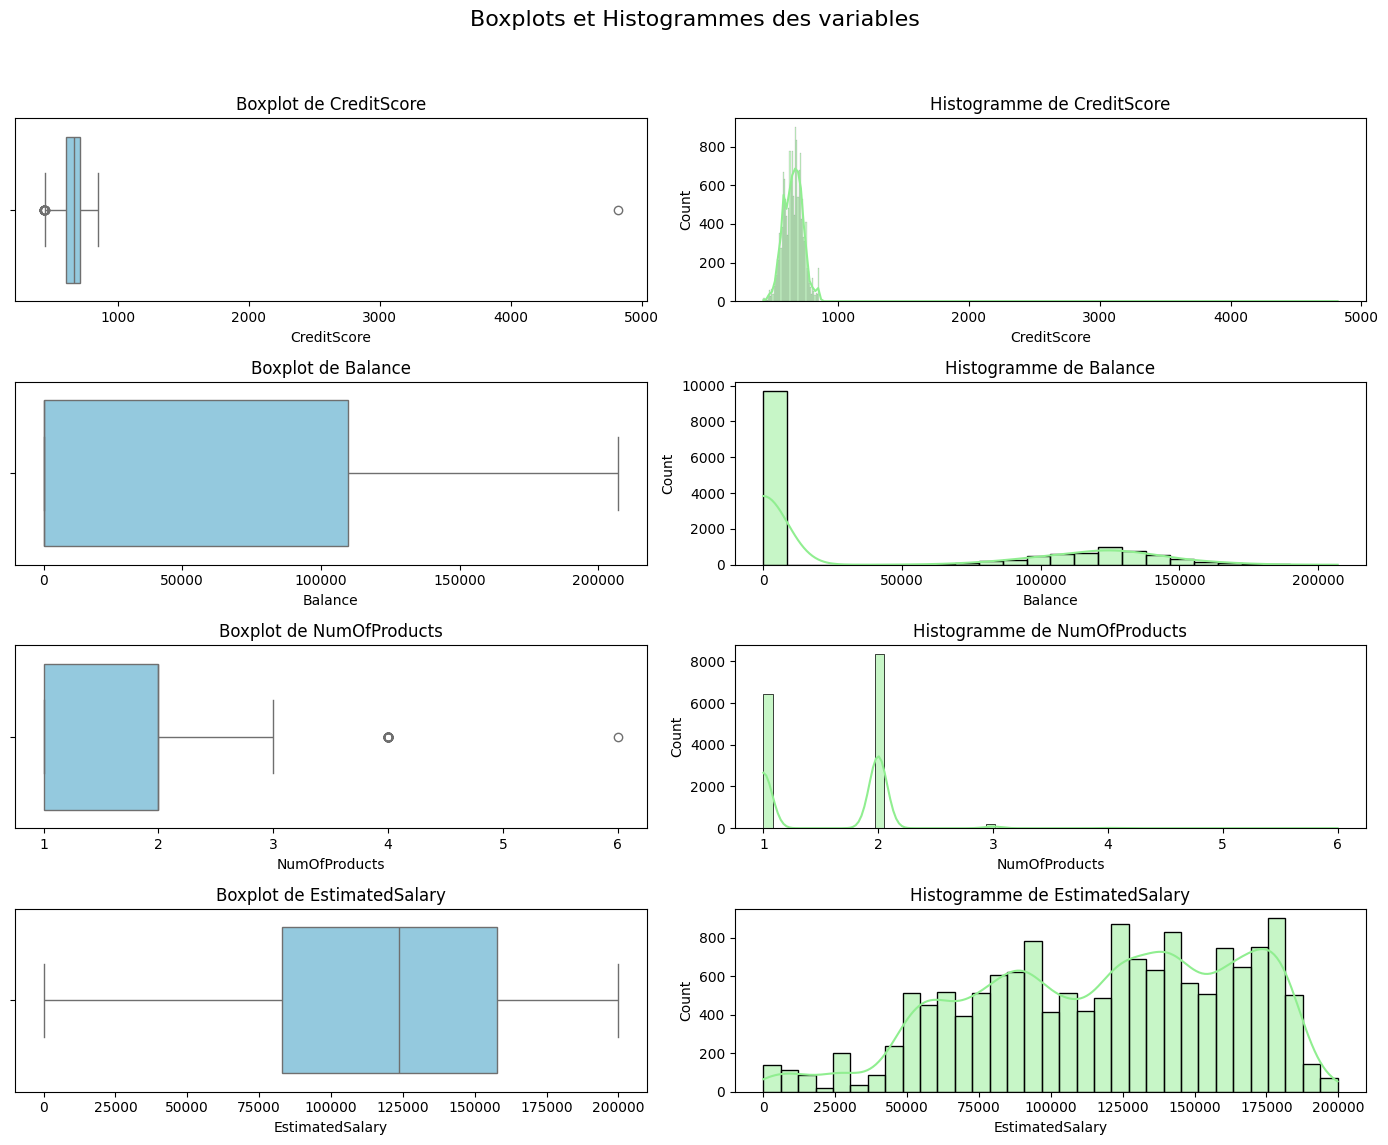

In [10]:
fig, axes = plt.subplots(4, 2, figsize=(14, 12))
fig.suptitle("Boxplots et Histogrammes des variables", fontsize = 16)

# Variables qui nous interessent
variables = ["CreditScore", "Balance", "NumOfProducts", "EstimatedSalary"]

for i, var in enumerate(variables):
  # Boxplot
  sns.boxplot(x = data[var], ax = axes[i][0], color = "skyblue")
  axes[i][0].set_title(f"Boxplot de {var}")

  # Histogram
  sns.histplot(x = data[var], kde = True, ax = axes[i][1], color = "lightgreen")
  axes[i][1].set_title(f"Histogramme de {var}")

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

Les valeurs semblent être logiques, à l’exception du **CreditScore**, qui nécessite un traitement spécifique. Cependant, après avoir testé la suppression de cette valeur aberrante, nous avons constaté une baisse significative des performances des modèles. Par conséquent, nous avons décidé de la conserver.

### Vérification des doublons 

In [11]:
selected_columns = [col for col in data.columns if col not in ['id', 'Exited']]
duplicate_count = data.duplicated(subset=selected_columns).sum()

print(f"Il y a {duplicate_count} individus qui présentent exactement les mêmes caractéristiques.")

Il y a 0 individus qui présentent exactement les mêmes caractéristiques.


### Analyse de la variable cible Exited

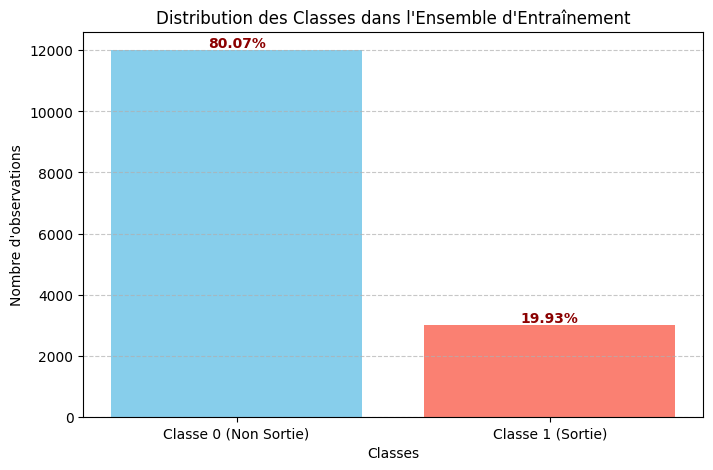

In [12]:
class_counts = data['Exited'].value_counts()

plt.figure(figsize=(8, 5))
bars = plt.bar(class_counts.index, class_counts.values, color=['skyblue', 'salmon'])

plt.xlabel('Classes')
plt.ylabel('Nombre d\'observations')
plt.xticks([0, 1], ['Classe 0 (Non Sortie)', 'Classe 1 (Sortie)'])
plt.title('Distribution des Classes dans l\'Ensemble d\'Entraînement')

total = class_counts.sum()
for i, value in enumerate(class_counts.values):
    percentage = (value / total) * 100
    plt.text(i, value + 0.05, f'{percentage:.2f}%', ha='center', va='bottom', fontweight='bold', color='darkred')

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

On remarque qu'il ya un désequilibre de classe. on testera quelques techniques de rééchantillonnage par la suite

In [13]:
# Liste des featutres numériques dans data
numeric_features = ['CreditScore', 'Age', 'Tenure', 'Balance', 'EstimatedSalary', 'NumOfProducts']
# Liste des features catégorielles dans data
categorical_features = ['Geography', 'Gender', 'HasCrCard', 'IsActiveMember']

### Analyse bivariée des variables 

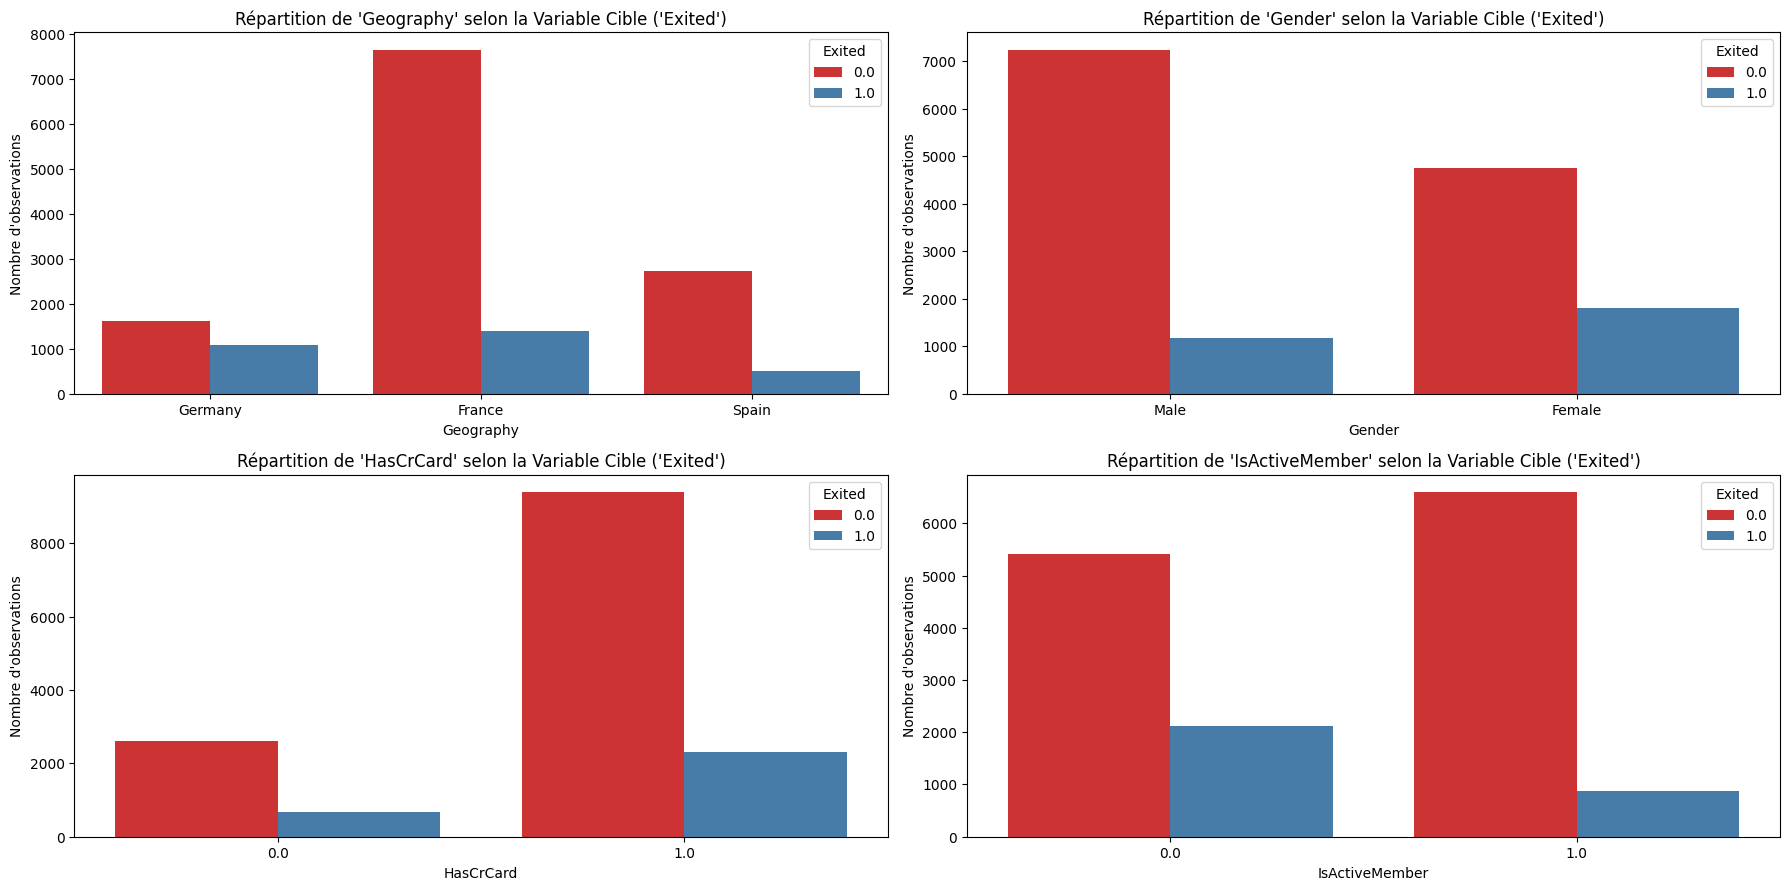

In [14]:
plt.figure(figsize=(18, 13))

# Visualiser chaque features catégorielle selon la variable cible
for i, feature in enumerate(categorical_features):
    plt.subplot(3, 2, i+1)
    sns.countplot(x=data[feature], hue=data['Exited'], palette='Set1', dodge=True)
    plt.title(f"Répartition de '{feature}' selon la Variable Cible ('Exited')")
    plt.xlabel(feature)
    plt.ylabel('Nombre d\'observations')

plt.tight_layout()
plt.show()

- La France domine en nombre de clients
- L'Allemagne montre le plus fort taux de départ proportionnel
- Les femmes partent proportionnellement plus souvent
- Avoir une carte de crédit fidélise
- L'inactivité est un signal fort de départ futur

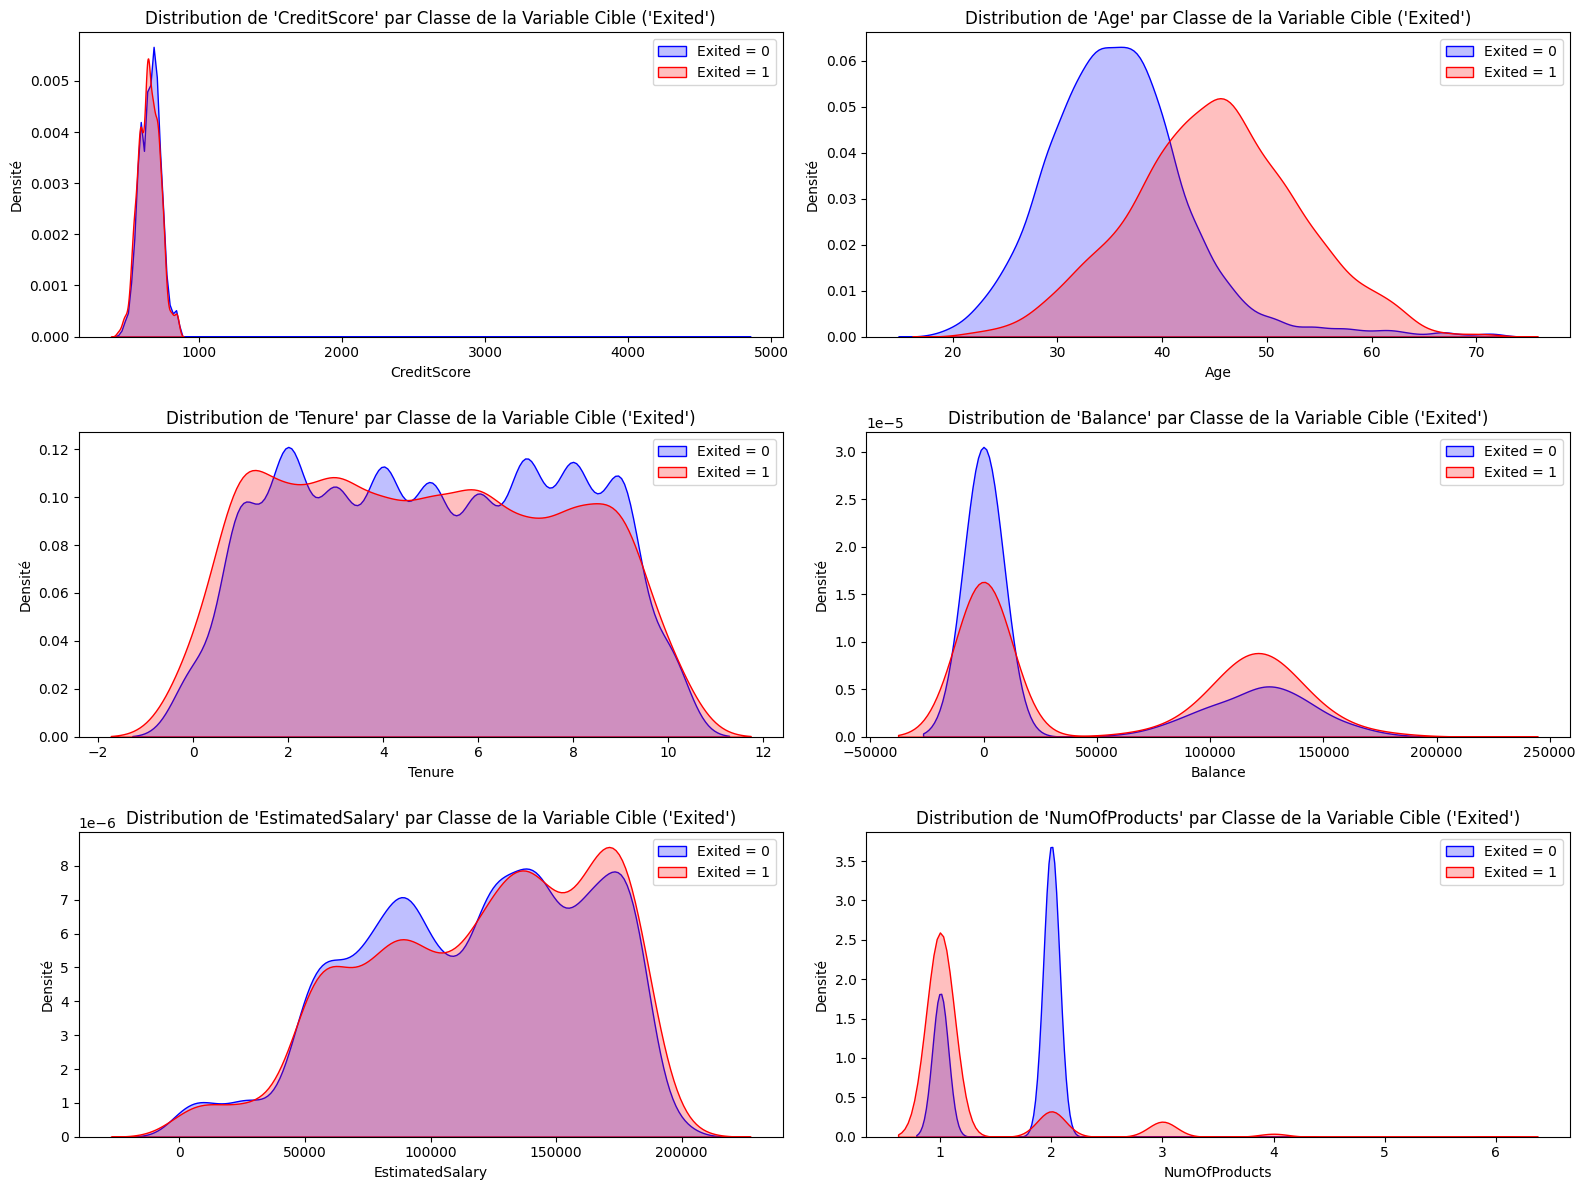

In [15]:
plt.figure(figsize=(16, 12))

# Visualiser la distribution de chaque caractéristique numérique selon la variable cible
for i, feature in enumerate(numeric_features):
    plt.subplot(3, 2, i+1)
    sns.kdeplot(data[feature][data['Exited'] == 0], label='Exited = 0', color='blue', fill=True)
    sns.kdeplot(data[feature][data['Exited'] == 1], label='Exited = 1', color='red', fill=True)
    plt.title(f"Distribution de '{feature}' par Classe de la Variable Cible ('Exited')")
    plt.xlabel(feature)
    plt.ylabel('Densité')
    plt.legend()

plt.tight_layout()
plt.show()

### Analyse des corrélations (variables numériques)

In [16]:
# Variables qualtitatives et quantitatives
categorical_features = ['Geography', 'Gender']
numerical_features = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary']

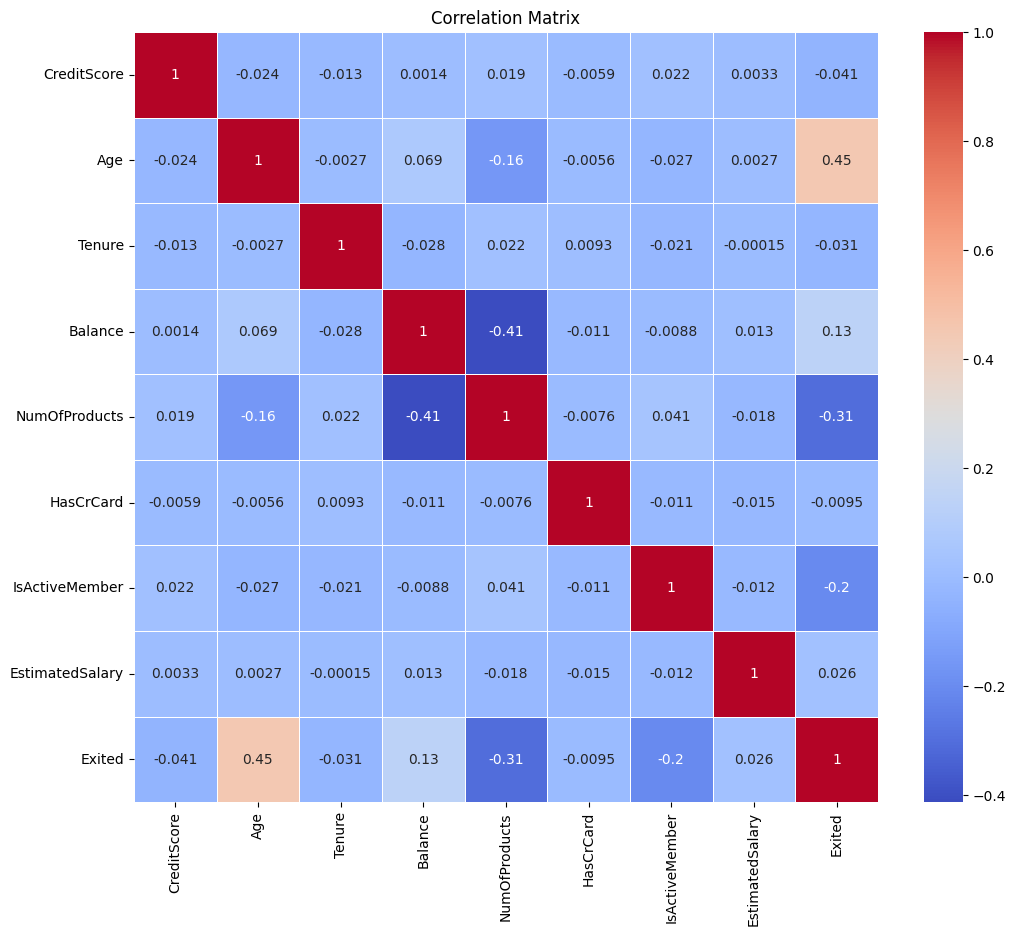

In [17]:
correlations = data[numerical_features + ['Exited']].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(correlations, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

- On remarque qu'il y a peu de corrélations entre les variables numériques.
- La corrélation entre **`Age`** et **`Exited`** est de **0.45**, ce qui est relativement élevé. Cela suggère que l'âge est une variable très importante pour prédire si un client quitte la banque.
- **`Balance`** a une corrélation de **0.13** avec **`Exited`**, ce qui indique que les clients ayant un certain niveau de balance sont plus susceptibles de quitter.
- **`NumOfProducts`** a une **corrélation négative (-0.31)** avec **`Exited`**, ce qui pourrait indiquer que plus un client utilise de produits, moins il est susceptible de quitter. 
- **`IsActiveMember`** a une **corrélation négative (-0.2)** avec **`Exited`**. Cela montre que l'engagement est un facteur important pour la rétention des clients.
- Il existe une **corrélation négative** entre **`NumOfProducts`** et **`Balance`**, ainsi qu’entre **`NumOfProducts`** et **`Age`**.
- Nous analyserons par la suite la corrélation avec les variables catégoriques.

### Analyse des corrélations (variables catégorielles)

In [19]:
# Cramer's V pour correlation entre variables categoriques
def cramers_v(contingency_table):
    chi2, _, _, _ = chi2_contingency(contingency_table)
    n = contingency_table.sum().sum()
    phi2 = chi2 / n
    r, k = contingency_table.shape
    phi2_corr = max(0, phi2 - ((k - 1) * (r - 1)) / (n - 1))
    r_corr = r - ((r - 1) ** 2) / (n - 1)
    k_corr = k - ((k - 1) ** 2) / (n - 1)
    return np.sqrt(phi2_corr / min((k_corr - 1), (r_corr - 1)))

categorical_correlations = {}

# Corrélations entre variables catégoriques
for i, cat1 in enumerate(categorical_features):
    for cat2 in categorical_features[i+1:]:
        contingency_table = pd.crosstab(data[cat1], data[cat2])
        categorical_correlations[(cat1, cat2)] = cramers_v(contingency_table)

# Corrélations entre chaque variable catégorielle et la variable cible (Exited)
for cat in categorical_features:
    contingency_table = pd.crosstab(data[cat], data['Exited'])
    categorical_correlations[(cat, 'Exited')] = cramers_v(contingency_table)

categorical_correlations

{('Geography', 'Gender'): 0.02186418822932761,
 ('Geography', 'Exited'): 0.23569787581852736,
 ('Gender', 'Exited'): 0.1687277872702606}

- Il y a très peu d'association entre la région géographique et le genre des clients
- La corrélation entre **`Geography`** et **`Exited`** est de **0.2357**. Cela indique une corrélation modérée entre la localisation géographique et la probabilité de quitter la banque. La région du client a donc un impact non négligeable sur la rétention.
- La corrélation entre **`Gender`** et **`Exited`** est de **0.1688**. Cela montre une corrélation faible à modérée entre le genre du client et sa décision de quitter la banque. 

Dans ce qui suit, nous allons encoder les variables catégoriques, puis effectuer un test de corrélation de Spearman afin de vérifier si les variables numériques et catégoriques sont corrélées entre elles.

### Test de normalité des variables numériques


Avant de mettre à l’échelle les variables numériques, nous allons tester si elles suivent une loi normale ou non. Cela permettra de déterminer s’il est préférable de les normaliser avec un MinMaxScaler ou de les standardiser avec un StandardScaler.

In [20]:
# Variables numériques continues et binaires
numerical_features = ['CreditScore', 'Age', 'Balance', 'EstimatedSalary', 'Tenure', 'NumOfProducts']
binary_features = ['HasCrCard', 'IsActiveMember']

# Variables catégoriques
categorical_features = ['Geography', 'Gender']

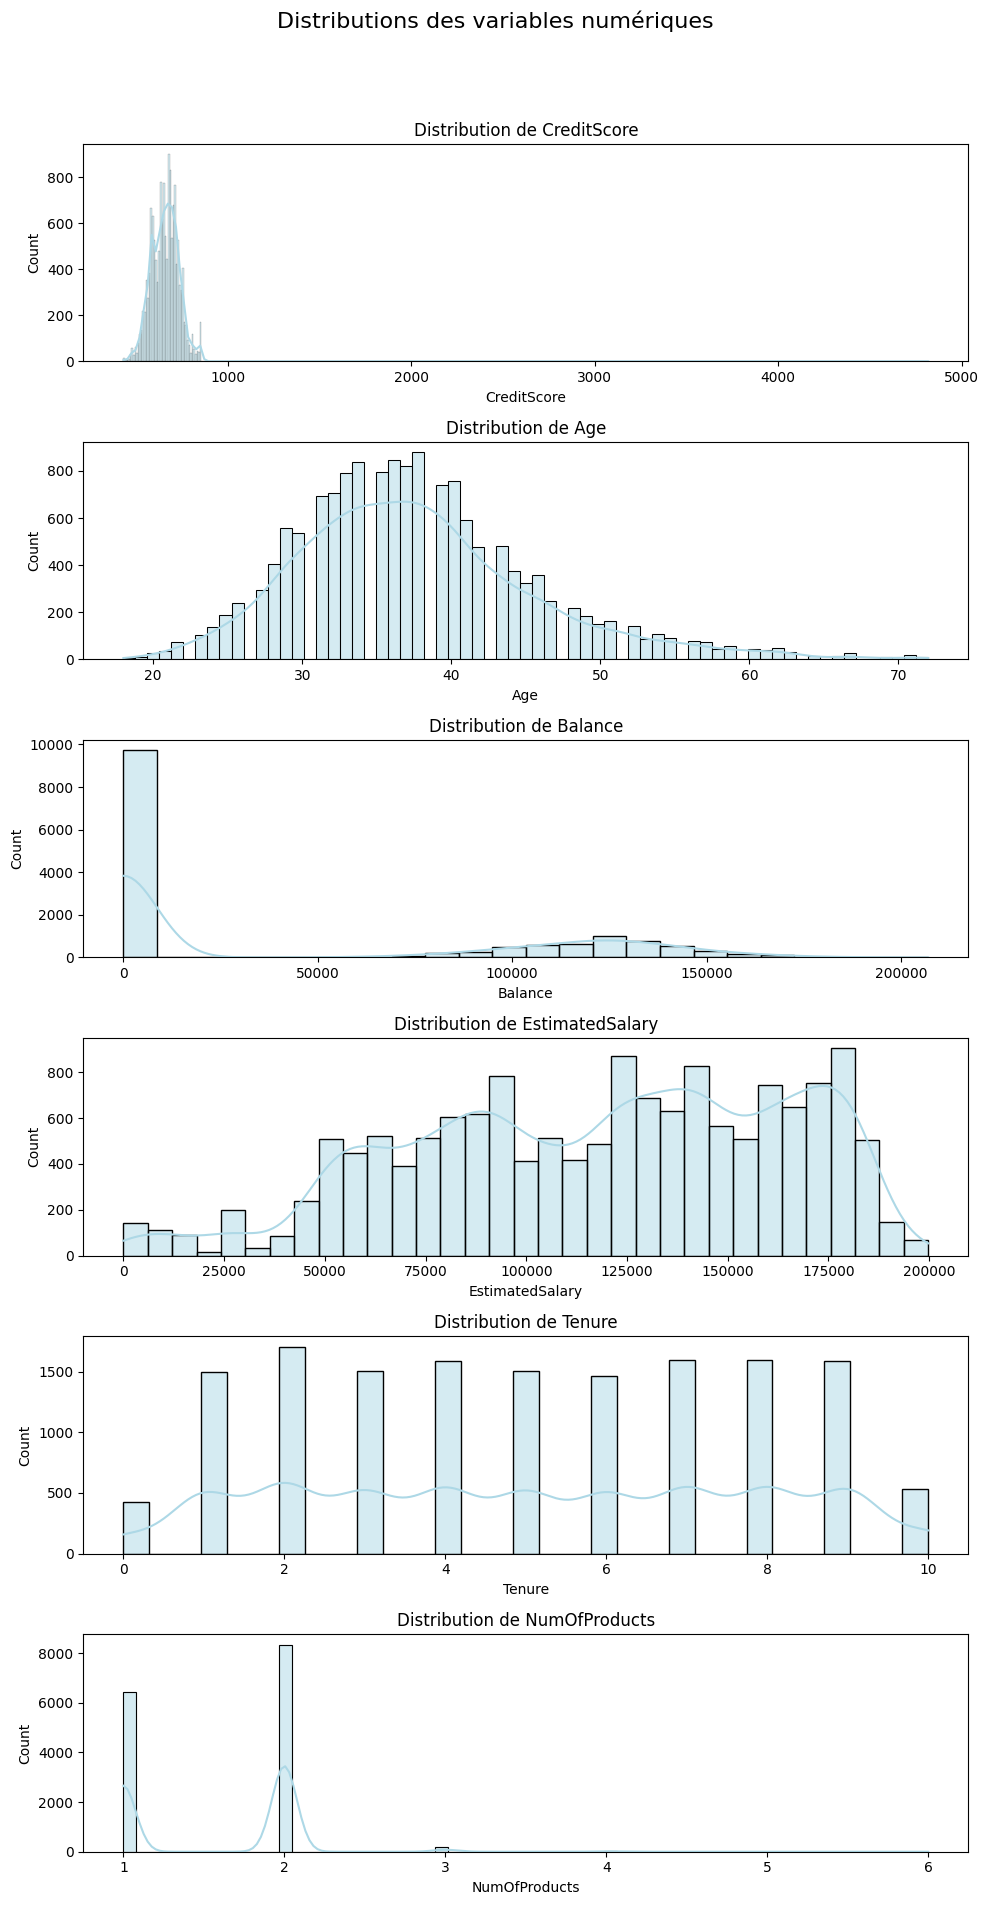

In [21]:
# Visualisation de la distribution des variables numeriques
fig, axes = plt.subplots(len(numerical_features), 1, figsize=(10, 20))
fig.suptitle("Distributions des variables numériques", fontsize=16)

# Plot histograms
for i, feature in enumerate(numerical_features):
    sns.histplot(data[feature], kde=True, ax=axes[i], color="lightblue")
    axes[i].set_title(f"Distribution de {feature}")

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

On remarque que la plupart des variables ne suivent pas une distribution normale. On fera un test de normalité pour vérifier ceci.

In [22]:
# verifions la normalite des variables numeriques avec le test Anderson-Darling
anderson_results = {}
for feature in numerical_features:
    result = anderson(data[feature].dropna())
    anderson_results[feature] = result.statistic

anderson_results

{'CreditScore': 47.657945175007626,
 'Age': 128.9802740603409,
 'Balance': 2394.6688929559386,
 'EstimatedSalary': 135.85417571817925,
 'Tenure': 240.46111283013488,
 'NumOfProducts': 2349.7524345467464}

On a obtenu des valeurs tres grandes ce qui signifie que les variables s'éloignent beaucoup de la distribution normale. Pour normaliser les données, on va alors utiliser le MinmaxScaler au lieu de StandardScaler.

### Feature Engineering

In [23]:
# Create new features
data['Tenure_to_Age_Ratio'] = data['Tenure'] / data['Age']
data['Balance_to_Salary_Ratio'] = data['Balance'] / data['EstimatedSalary']
data['Avg_Product_Per_Tenure'] = data['NumOfProducts'] / data['Tenure'].replace(0, 1)  # Avoid division by zero
data['Credit_to_Age_Ratio'] = data['CreditScore'] / data['Age']
threshold = data['Balance'].quantile(0.9)  # 90th percentile
data['High_Balance_Indicator'] = (data['Balance'] > threshold).astype(int)

data.head()

,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Tenure_to_Age_Ratio,Balance_to_Salary_Ratio,Avg_Product_Per_Tenure,Credit_to_Age_Ratio,High_Balance_Indicator
0,0,15713774.0,Hsieh,683.0,Germany,Male,49.0,7.0,123837.86,2.0,1.0,1.0,138700.75,1.0,0.142857,0.892842,0.285714,13.938776,0
1,1,15682533.0,Hs?eh,608.0,France,Female,30.0,10.0,0.00,2.0,1.0,1.0,146723.72,0.0,0.333333,0.000000,0.200000,20.266667,0
2,2,15791550.0,Tsou,539.0,France,Female,32.0,8.0,0.00,1.0,1.0,1.0,94873.60,0.0,0.250000,0.000000,0.125000,16.843750,0
3,3,15762762.0,Chiawuotu,530.0,Spain,Female,39.0,8.0,0.00,2.0,0.0,0.0,177896.93,0.0,0.205128,0.000000,0.250000,13.589744,0
4,4,15756475.0,Nnamdi,613.0,France,Female,45.0,10.0,0.00,2.0,1.0,1.0,116748.14,0.0,0.222222,0.000000,0.200000,13.622222,0


In [26]:
# Step 1: Split the data
X = data.drop(columns=['id', 'CustomerId', 'Surname', 'Exited'])
y = data['Exited']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 2: Define transformers for scaling and encoding
categorical_columns = ["Geography", "Gender"]  # Specify categorical columns (Age_Bin is not created yet)
numerical_columns = ["CreditScore", "Balance", "EstimatedSalary", "Age"]  # Specify numerical columns

# Create the preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ("num", MinMaxScaler(), numerical_columns),  # Normalize numerical features
        ("cat", OneHotEncoder(drop="first"), categorical_columns)  # Encode categorical features
    ],
    remainder="passthrough"  # Keep other columns untouched
)

# Step 3: Fit on training data and transform both train and validation sets
X_train_transformed = preprocessor.fit_transform(X_train)
X_val_transformed = preprocessor.transform(X_val)

# Step 4: Get the transformed feature names
transformed_columns = preprocessor.get_feature_names_out()

# Convert transformed data back to DataFrame for better interpretability
X_train_transformed = pd.DataFrame(X_train_transformed, columns=transformed_columns, index=X_train.index)
X_val_transformed = pd.DataFrame(X_val_transformed, columns=transformed_columns, index=X_val.index)

# Display the transformed training dataset
X_train_transformed.head()

,num__CreditScore,num__Balance,num__EstimatedSalary,num__Age,cat__Geography_Germany,cat__Geography_Spain,cat__Gender_Male,remainder__Tenure,remainder__NumOfProducts,remainder__HasCrCard,remainder__IsActiveMember,remainder__Tenure_to_Age_Ratio,remainder__Balance_to_Salary_Ratio,remainder__Avg_Product_Per_Tenure,remainder__Credit_to_Age_Ratio,remainder__High_Balance_Indicator
9839,0.030545,0.000000,0.862517,0.351852,0.0,0.0,1.0,2.0,2.0,1.0,0.0,0.054054,0.000000,1.000000,15.270270,0.0
9680,0.057670,0.597445,0.441595,0.666667,0.0,0.0,0.0,10.0,1.0,1.0,0.0,0.185185,1.397945,0.100000,12.666667,0.0
7093,0.034420,0.639270,0.388390,0.370370,0.0,0.0,1.0,4.0,2.0,1.0,0.0,0.105263,1.699456,0.500000,15.315789,0.0
11293,0.029861,0.602740,0.436230,0.314815,1.0,0.0,1.0,5.0,1.0,1.0,0.0,0.142857,1.427582,0.200000,16.057143,0.0
820,0.058810,0.000000,0.481556,0.888889,0.0,0.0,1.0,3.0,2.0,1.0,1.0,0.045455,0.000000,0.666667,10.439394,0.0


# <span style="color:lightblue;">Modélisation</span>


In [27]:
# Fonction pour effectuer une validation croisée sur un modèle et retourner les AUC scores.
def cross_validate_model(model, X, y, cv_folds=5):
    print(f"Starting cross-validation with {cv_folds} folds...")
    if isinstance(X, pd.DataFrame):
        X = X.values
    if isinstance(y, pd.Series):
        y = y.values

    skf = StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=42)
    auc_scores = []

    for train_index, val_index in skf.split(X, y):
        # Split the data
        X_train, X_val = X[train_index], X[val_index]
        y_train, y_val = y[train_index], y[val_index]
        
        # Fit the model
        model.fit(X_train, y_train)
        
        # Predict probabilities
        y_val_pred_prob = model.predict_proba(X_val)[:, 1]
        
        # Calculate AUC for this fold
        auc_score = roc_auc_score(y_val, y_val_pred_prob)
        auc_scores.append(auc_score)

    # Calculate mean and standard deviation of AUC scores
    scores_mean = np.mean(auc_scores)
    scores_std = np.std(auc_scores)

    print(f"Scores AUC of each fold : {auc_scores}")
    print(f"Mean of AUC scores : {scores_mean:.4f}")
    print(f"Standard Deviation of AUC scores : {scores_std:.4f}")
    
    return scores_mean, scores_std

In [28]:
# Fonction pour entraîner un modèle et évaluer l'AUC sur l'ensemble de validation
def train_and_evaluate_model(model, X_train, y_train, X_val, y_val, model_name):

    # Create the 'models' folder if it doesn't exist
    models_dir = os.path.join(os.getcwd(), 'models')
    os.makedirs(models_dir, exist_ok=True)

    # Full path to the model file
    model_path = os.path.join(models_dir, model_name)
    
    try:
        # Check if a pre-trained model exists
        print(f"Looking for saved model '{model_path}'...")
        model = joblib.load(model_path)
        print(f"Loaded pre-trained model from {model_path}.")
    except FileNotFoundError:
        print(f"No pre-trained model found. Training model from scratch...")


    model.fit(X_train, y_train)

    joblib.dump(model, model_path)
    print(f"Model saved as {model_path}.")
    
    y_val_pred_prob = model.predict_proba(X_val)[:, 1]
    auc_score = roc_auc_score(y_val, y_val_pred_prob)
    print(f"AUC Score of the model {model.__class__.__name__}: {auc_score:.4f}")
    
    return model, auc_score

In [29]:
def evaluate_classification_model_with_comparison(model, X_train, y_train, X_val, y_val):
    """
    Evaluate a classification model by generating confusion matrix, classification report,
    and comparing ROC curves for both training and validation datasets.

    Parameters:
        model: Trained classification model
        X_train: Training feature dataset
        y_train: Training target dataset
        X_val: Validation feature dataset
        y_val: Validation target dataset

    Returns:
        conf_matrix: Confusion matrix for validation set
        classif_report: Classification report for validation set
    """

    y_train_pred_prob = model.predict_proba(X_train)[:, 1]
    y_val_pred_prob = model.predict_proba(X_val)[:, 1]
    y_val_pred = model.predict(X_val)

    auc_train = roc_auc_score(y_train, y_train_pred_prob)
    auc_val = roc_auc_score(y_val, y_val_pred_prob)

    print(f"AUC Score on Training Set: {auc_train:.4f}")
    print(f"AUC Score on Validation Set: {auc_val:.4f}")

    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # Confusion Matrix
    conf_matrix = confusion_matrix(y_val, y_val_pred)
    sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='g', ax=axes[0])
    axes[0].set_xlabel('Classe Prédite')
    axes[0].set_ylabel('Classe Réelle')
    axes[0].set_title(f'Matrice de Confusion pour le Modèle {model.__class__.__name__}')

    # ROC Curve
    fpr_train, tpr_train, _ = roc_curve(y_train, y_train_pred_prob)
    fpr_val, tpr_val, _ = roc_curve(y_val, y_val_pred_prob)
    axes[1].plot(fpr_train, tpr_train, label=f'Train ROC (AUC = {auc_train:.4f})', color='blue')
    axes[1].plot(fpr_val, tpr_val, label=f'Validation ROC (AUC = {auc_val:.4f})', color='green', linestyle='--')
    axes[1].plot([0, 1], [0, 1], color='gray', linestyle='--', label='Baseline (AUC = 0.5)')
    axes[1].set_xlabel('False Positive Rate')
    axes[1].set_ylabel('True Positive Rate')
    axes[1].set_title('ROC Curve Comparison')
    axes[1].legend(loc='lower right')

    plt.tight_layout()
    plt.show()

    # classification report for validation set
    classif_report = classification_report(y_val, y_val_pred)
    print(f"Classification Report for {model.__class__.__name__}:\n")
    print(classif_report)

    return conf_matrix, classif_report

In [30]:
# Fonction pour entraîner un modèle, prédire sur l'ensemble de test, et sauvegarder les prédictions dans un fichier CSV
def save_predictions_to_csv(model, X_test, test_id, output_file):
    
    # Prédire les probabilités sur l'ensemble de test
    y_test_pred_prob = model.predict_proba(X_test)[:, 1]

    predictions_df = pd.DataFrame({
        'id': test_id,
        'Exited': y_test_pred_prob
    })

    # Sauvegarde des prédictions dans un fichier CSV
    predictions_df.to_csv(output_file, index=False)
    print(f"Predictions were saved in the file : {output_file}")

    return predictions_df

In [31]:
# Fonction pour entraîner le dataset train complet avec le modèle selectionne, prédire sur l'ensemble de test, et sauvegarder les prédictions dans un fichier CSV
def train_and_save_final_predictions(model, X_full, y_full, X_test, test_id, model_name, output_file):

    models_dir = os.path.join(os.getcwd(), 'models')
    os.makedirs(models_dir, exist_ok=True)
    
    model_path = os.path.join(models_dir, model_name)
    
    try:
        # Check if a pre-trained model exists
        print(f"Looking for saved model '{model_path}'...")
        model = joblib.load(model_path)
        print(f"Loaded pre-trained model from {model_path}.")
    except FileNotFoundError:
        print(f"No pre-trained model found. Training model from scratch...")    
    
        model.fit(X_full, y_full)
        print(f"The model {model.__class__.__name__} is trained on the full train dataset")

        # Save the model for future use
        joblib.dump(model, model_path)
        print(f"Model saved as {model_path}.")
    
    y_test_pred_prob = model.predict_proba(X_test)[:, 1]
    predictions_df = pd.DataFrame({'id': test_id, 'Exited': y_test_pred_prob})

    predictions_df.to_csv(output_file, index=False)
    print(f"Predictions were saved in the file : {output_file}")

    return predictions_df

In [32]:
def tune_hyperparameters(objective, n_trials=200, study_name="optuna_study", resume_study=False):
    """
    This function tunes hyperparameters using Optuna.
    
    Args:
    - objective: The objective function that Optuna will call.
    - n_trials: Number of trials to run for Optuna.
    - study_name: Name of the study (for saving and reloading).
    - resume_study: If True, resume from an existing study if it exists.

    Returns:
    - best_params: The best parameters found during the study.
    - best_score: The best AUC score achieved.
    - study: The Optuna study (to view the history of trials).
    """
    # Get the current directory where the script is running
    base_dir = os.path.dirname(os.path.abspath(__file__)) if '__file__' in globals() else os.getcwd()
    
    # Create the 'study' folder if it doesn't exist
    studies_dir = os.path.join(base_dir, 'study')
    os.makedirs(studies_dir, exist_ok=True)
    
    # Full path to the study file
    study_path = os.path.join(studies_dir, f"{study_name}.pkl")

    if resume_study:
        try:
            study = joblib.load(study_path)
            print(f"Resuming previous study '{study_name}' with {len(study.trials)} trials.")
        except FileNotFoundError:
            print(f"No previous study found. Starting new study '{study_name}'.")
            study = optuna.create_study(direction='maximize')
    else:
        study = optuna.create_study(direction='maximize')

    study.optimize(objective, n_trials=n_trials)
    
    # Save the study to the designated path
    joblib.dump(study, study_path)
    print(f"Study saved to {study_path}")

    best_params = study.best_params
    best_score = study.best_value

    print(f"Best AUC: {best_score}")
    print(f"Best Parameters: {best_params}")
    
    return best_params, best_score, study


# <span style="color:lightblue;">Regression logistique</span>

#### Test des résultat sur l'ensemble de validation

In [34]:
# Régression logistique
reg_log_base_model = LogisticRegression(
    penalty='elasticnet', tol=0.0001, C=0.5, fit_intercept=True, intercept_scaling=1,
    class_weight='balanced', random_state=42, solver='saga', max_iter=100, l1_ratio=0.5
)

auc_mean, auc_std = cross_validate_model(reg_log_base_model, X_train_transformed, y_train, cv_folds = 5)
reg_log_base_model, auc_score_reglog_base = train_and_evaluate_model(reg_log_base_model, X_train_transformed, y_train, X_val_transformed, y_val, model_name = "log_reg_base_FE.pkl")

Starting cross-validation with 5 folds...


/home/chahla/Bank-Churn-Prediction/.bankenv/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/chahla/Bank-Churn-Prediction/.bankenv/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/chahla/Bank-Churn-Prediction/.bankenv/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/chahla/Bank-Churn-Prediction/.bankenv/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/chahla/Bank-Churn-Prediction/.bankenv/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the 

Scores AUC of each fold : [0.8486312399355878, 0.856773491188678, 0.8663969357649373, 0.8668573905691954, 0.8601047723390673]
Mean of AUC scores : 0.8598
Standard Deviation of AUC scores : 0.0067
Looking for saved model '/home/chahla/Bank-Churn-Prediction/src/models/log_reg_base_FE.pkl'...
No pre-trained model found. Training model from scratch...
Model saved as /home/chahla/Bank-Churn-Prediction/src/models/log_reg_base_FE.pkl.
AUC Score of the model LogisticRegression: 0.8559


/home/chahla/Bank-Churn-Prediction/.bankenv/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


AUC Score on Training Set: 0.8645
AUC Score on Validation Set: 0.8559


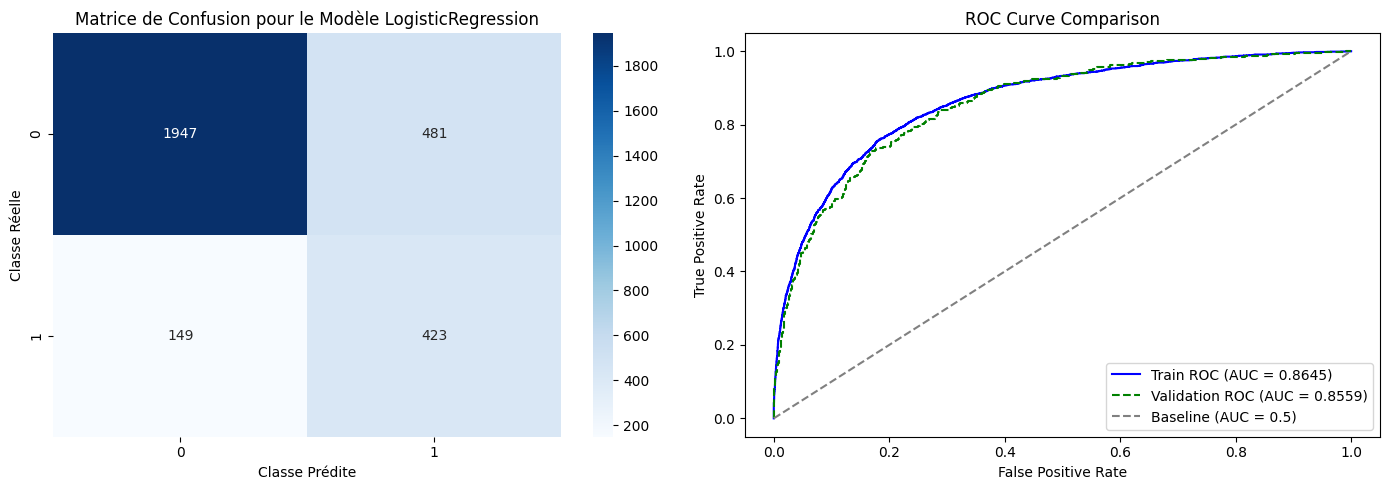

Classification Report for LogisticRegression:

              precision    recall  f1-score   support

         0.0       0.93      0.80      0.86      2428
         1.0       0.47      0.74      0.57       572

    accuracy                           0.79      3000
   macro avg       0.70      0.77      0.72      3000
weighted avg       0.84      0.79      0.81      3000



In [35]:
conf_matrix, classif_report = evaluate_classification_model_with_comparison(
    model=reg_log_base_model,
    X_train=X_train_transformed,
    y_train=y_train,
    X_val=X_val_transformed,
    y_val=y_val
)

**AUC Score (Training & Validation) et ROC Curve**:
   - **Training Set**: L'AUC est de **0.8839**, ce qui indique que le modèle Logistic Regression est capable de discriminer correctement les classes sur l'ensemble d'entraînement avec une bonne performance.
   - **Validation Set**: L'AUC est de **0.8846**, très proche de l'AUC du Training Set. Cela montre que le modèle généralise bien et qu'il n'y a pas de surapprentissage (overfitting).

**Matrice de confusion** :
   - Classe **0 (Non Sortie)** :
     - **1989** instances correctement classées comme **0** (vrais négatifs).
     - **439** instances mal classées comme **1** (faux positifs).
   - Classe **1 (Sortie)** :
     - **453** instances correctement classées comme **1** (vrais positifs).
     - **119** instances mal classées comme **0** (faux négatifs).
  Le modèle a une bonne capacité à identifier les clients qui restent dans la banque (classe 0), mais il a plus de difficulté à identifier correctement ceux qui quittent (classe 1), comme le montre le nombre relativement élevé de faux négatifs.

**Classification Report**:
   - **Classe 0 (Non Sortie)** :
     - **Précision** : 94% → Parmi les clients prédits comme restant (classe 0), 94% sont effectivement corrects.
     - **Rappel** : 82% → Parmi les clients qui restent réellement, 82% sont correctement identifiés.
     - **F1-score** : 0.88 → Une bonne balance entre précision et rappel pour la classe 0.
   - **Classe 1 (Sortie)** :
     - **Précision** : 51% → Parmi les clients prédits comme quittant la banque (classe 1), seulement 51% sont corrects.
     - **Rappel** : 79% → Parmi les clients qui quittent réellement, 79% sont correctement identifiés.
     - **F1-score** : 0.62 → Moins performant que la classe 0 en raison de la faible précision.

In [ ]:
# Sauvegarder les prédictions sur l'ensemble de test
predictions_val_reglog_base = save_predictions_to_csv(
    model=reg_log_base_model,
    X_test=test_transformed,
    test_id=test['id'],
    output_file="../data/val/reglog_base.csv"
)

#### Test sur l'ensemble test

Maintenant qu'on a testé sur l'ensemble de validation, on va réentrainer le modele sur l'ensemble des données et le tester sur test (sur kaggle).

In [ ]:
predictions_final_reglog = train_and_save_final_predictions(
    model=reg_log_base_model,
    X_full=data_transformed_full,
    y_full=data['Exited'],
    X_test=test_transformed,
    test_id=test['id'],
    model_name = 'log_reg_final.pkl',
    output_file="../data/test/reglog_final.csv"
)


# <span style="color:lightblue;">Random Forest</span>

#### Test des résultat sur l'ensemble de validation

In [36]:
# Random Forest
random_forest_model = RandomForestClassifier(
    class_weight = 'balanced', 
    bootstrap = True, 
    max_depth = 15, 
    random_state=42, 
    n_estimators=200
)

auc_mean, auc_std = cross_validate_model(random_forest_model, X_train_transformed, y_train, cv_folds = 5)
random_forest_model, auc_score_random_forest_base = train_and_evaluate_model(random_forest_model, X_train_transformed, y_train, X_val_transformed, y_val, model_name = 'rf_base_FE.pkl')

Starting cross-validation with 5 folds...
Scores AUC of each fold : [0.918216221645493, 0.9232534228451763, 0.9334610457392295, 0.9370363101502786, 0.9241910229645094]
Mean of AUC scores : 0.9272
Standard Deviation of AUC scores : 0.0069
Looking for saved model '/home/chahla/Bank-Churn-Prediction/src/models/rf_base_FE.pkl'...
No pre-trained model found. Training model from scratch...
Model saved as /home/chahla/Bank-Churn-Prediction/src/models/rf_base_FE.pkl.
AUC Score of the model RandomForestClassifier: 0.9168


AUC Score on Training Set: 0.9997
AUC Score on Validation Set: 0.9168


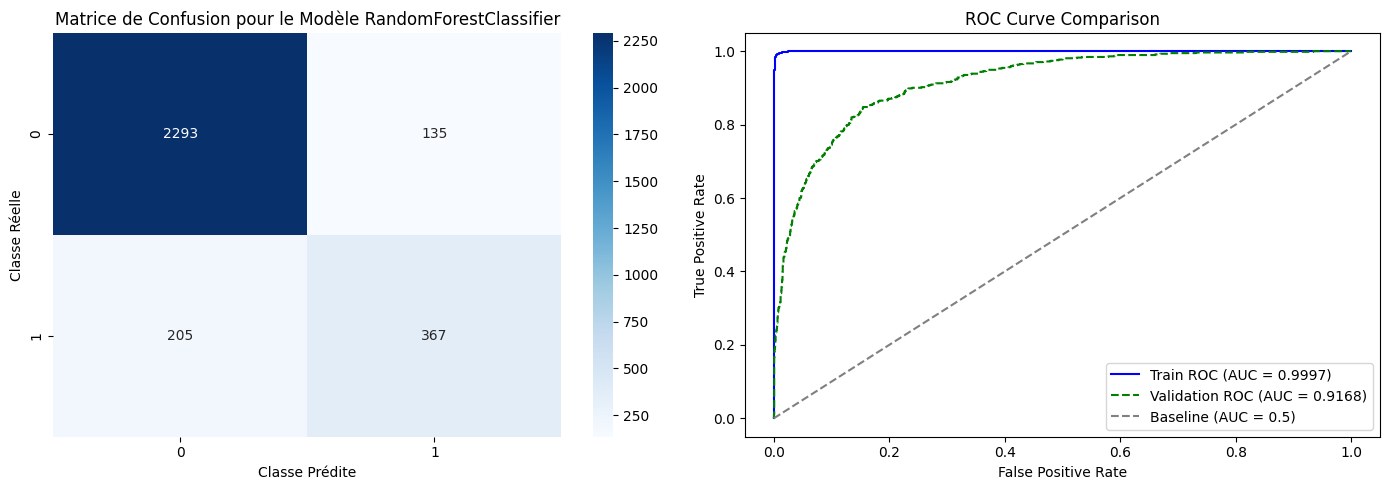

Classification Report for RandomForestClassifier:

              precision    recall  f1-score   support

         0.0       0.92      0.94      0.93      2428
         1.0       0.73      0.64      0.68       572

    accuracy                           0.89      3000
   macro avg       0.82      0.79      0.81      3000
weighted avg       0.88      0.89      0.88      3000



In [37]:
conf_matrix, classif_report = evaluate_classification_model_with_comparison(
    model=random_forest_model,
    X_train=X_train_transformed,
    y_train=y_train,
    X_val=X_val_transformed,
    y_val=y_val
)

**Performances globales** :
   - **AUC Entraînement** : Très élevé (0.9997), indiquant un surapprentissage.
   - **AUC Validation** : Bonne (0.9212), mais nettement inférieure à celle de l'entraînement.

**Classe majoritaire (Classe 0)** :
   - Très bonnes performances avec un F1-score de **0.93**, un rappel de **94%** et une précision de **92%**.

**Classe minoritaire (Classe 1)** :
   - Performances modestes avec un F1-score de **0.69**, un rappel de **65%**, et une précision de **73%**.
   - Difficultés à bien identifier les clients quittant la banque.

Le modèle a de bonnes performances globales mais souffre de surapprentissage et a des difficultés avec la classe minoritaire. Des ajustements sont nécessaires pour améliorer la généralisation et l’équilibre entre les classes.

In [ ]:
# Sauvegarder les prédictions sur l'ensemble de test
predictions_val_random_forest_base = save_predictions_to_csv(
    model=random_forest_model,
    X_test=test_transformed,
    test_id=test['id'],
    output_file="../data/val/rf_base.csv"
)

#### Test sur l'ensemble test

In [ ]:
predictions_final_random_forest = train_and_save_final_predictions(
    model=random_forest_model,
    X_full=data_transformed_full,
    y_full=data['Exited'],
    X_test=test_transformed,
    test_id=test['id'], 
    model_name = 'rf_final.pkl' , 
    output_file="../data/test/rf_final.csv"
)

#### Test de Hyperparameter tuning avec Optuna

In [219]:
def objective_rf(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'max_depth': trial.suggest_int('max_depth', 10, 50),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2', None]),
        'bootstrap': trial.suggest_categorical('bootstrap', [True, False]),
    }

    model = RandomForestClassifier(**params, random_state=42)
    model.fit(X_train_transformed, y_train)
    y_val_pred_prob = model.predict_proba(X_val_transformed)[:, 1]
    auc_score = roc_auc_score(y_val, y_val_pred_prob)
    return auc_score

In [ ]:
best_rf_params, best_rf_score, rf_study = tune_hyperparameters(
    objective=objective_rf, 
    n_trials=0, # n_trials est 1000 de base mais on a mis 0 commen ca quand on relance le code, on a pas 1000 nouvelles iterations qui se lancent
    study_name="rf_study_v2", 
    resume_study=True
)

In [38]:
# Create the RandomForest model with best parameters
rf_model_optuna = RandomForestClassifier(
    n_estimators=110, 
    max_depth=10, 
    min_samples_split=20, 
    min_samples_leaf=1, 
    max_features='log2', 
    bootstrap=True, 
    random_state=42
)

# Cross-Validate the Model
auc_mean, auc_std = cross_validate_model(rf_model_optuna, X_train_transformed, y_train)
rf_model_optuna, auc_score_random_forest_base = train_and_evaluate_model(rf_model_optuna, X_train_transformed, y_train, X_val_transformed, y_val, model_name = 'rf_optuna_base_FE.pkl')

Starting cross-validation with 5 folds...
Scores AUC of each fold : [0.9241060965902771, 0.9292102588693729, 0.9396620887178868, 0.9397386514605152, 0.9268114097896789]
Mean of AUC scores : 0.9319
Standard Deviation of AUC scores : 0.0066
Looking for saved model '/home/chahla/Bank-Churn-Prediction/src/models/rf_optuna_base_FE.pkl'...
Loaded pre-trained model from /home/chahla/Bank-Churn-Prediction/src/models/rf_optuna_base_FE.pkl.
Model saved as /home/chahla/Bank-Churn-Prediction/src/models/rf_optuna_base_FE.pkl.
AUC Score of the model RandomForestClassifier: 0.9240


In [ ]:
conf_matrix, classif_report = evaluate_classification_model_with_comparison(
    model=rf_model_optuna,
    X_train=X_train_transformed,
    y_train=y_train,
    X_val=X_val_transformed,
    y_val=y_val
)

- **AUC Entraînement** : **0.9669** (très bon, pas de surapprentissage excessif).
- **AUC Validation** : **0.9293** (bonne généralisation).

- **Classe 0 (Non Sortie)** :
  - **Précision** : 92%, **Rappel** : 96%, **F1-score** : 0.94 (excellente performance).
- **Classe 1 (Sortie)** :
  - **Précision** : 78%, **Rappel** : 63%, **F1-score** : 0.69 (modéré, améliorable).

- **Accuracy** : **89%**, très bonne performance.
- **Macro avg F1** : **0.82**, équilibré entre les classes.

- Bonne généralisation et équilibre, mais le rappel pour la classe 1 peut être amélioré.

In [ ]:
# Sauvegarder les prédictions sur l'ensemble de test
predictions_val_rf_optuna_base = save_predictions_to_csv(
    model=rf_model_optuna,
    X_test=test_transformed,
    test_id=test['id'],
    output_file="../data/val/rf_optuna_base.csv"
)

In [ ]:
predictions_final_random_forest = train_and_save_final_predictions(
    model=rf_model_optuna,
    X_full=data_transformed_full,
    y_full=data['Exited'],
    X_test=test_transformed,
    test_id=test['id'],   
    model_name='rf_optuna_final.pkl',
    output_file="../data/test/rf_optuna_final.csv"
)

# <span style="color:lightblue;">SVM</span>

In [ ]:
svm_model = SVC(
    kernel='poly', 
    C=10, 
    gamma='scale', 
    class_weight='balanced',  
    probability=True, 
    random_state=42
)

auc_mean, auc_std = cross_validate_model(svm_model, X_train_transformed, y_train)
svm_model, auc_score_svm_base = train_and_evaluate_model(svm_model, X_train_transformed, y_train, X_val_transformed, y_val, model_name ='svm_base.pkl')

In [ ]:
conf_matrix, classif_report = evaluate_classification_model_with_comparison(
    model=svm_model,
    X_train=X_train_transformed,
    y_train=y_train,
    X_val=X_val_transformed,
    y_val=y_val
)

- **AUC Entraînement** : **0.9324**, 
- **AUC Validation** : **0.9168** → Bonne généralisation.
- Très bon rappel pour la classe 1 (**83%**), détectant efficacement les clients quittant la banque.
- Bonne généralisation avec un AUC de validation de **0.9168**.
- Le modèle SVC offre une performance solide et détecte bien les clients susceptibles de partir, mais la précision pour cette classe peut être renforcée.


#### Test des resultat sur l'ensemble de validation

In [ ]:
# Sauvegarder les prédictions sur l'ensemble de test
predictions_val_svm_base = save_predictions_to_csv(
    model=svm_model,
    X_test=test_transformed,
    test_id=test['id'],
    output_file="../data/val/svm_base.csv"
)

#### Test sur l'ensemble test

In [ ]:
predictions_final_svm = train_and_save_final_predictions(
    model=svm_model,
    X_full=data_transformed_full,
    y_full=data['Exited'],
    X_test=test_transformed,
    test_id=test['id'],  
    model_name ='svm_final.pkl',
    output_file="../data/test/svm_final.csv"
)


#### Tuning des hyperparamtres avec Optuna

In [236]:
def objective_svm_rbf_poly(trial):
    # Select kernel: RBF or Poly
    kernel = trial.suggest_categorical('kernel', ['rbf', 'poly'])
    
    # Common hyperparameters
    C = trial.suggest_float('C', 0.01, 10, log=True)  # Regularization parameter
    gamma = trial.suggest_float('gamma', 1e-4, 1, log=True)  # Kernel coefficient

    # Degree is only relevant for the polynomial kernel
    if kernel == 'poly':
        degree = trial.suggest_int('degree', 2, 5)  # Degree of the polynomial kernel
    else:
        degree = 3  # Default for other kernels (not used for RBF)

    # Create SVM model
    model = SVC(
        kernel=kernel,
        C=C,
        gamma=gamma,
        degree=degree,
        class_weight='balanced',  # To handle class imbalance
        probability=True,
        random_state=42
    )

    # Train and evaluate
    model.fit(X_train_transformed, y_train)
    y_val_pred_prob = model.predict_proba(X_val_transformed)[:, 1]

    # Compute AUC score
    auc_score = roc_auc_score(y_val, y_val_pred_prob)
    return auc_score

In [ ]:
best_svm_rbf_poly_params, best_svm_rbf_poly_score, svm_rbf_poly_study = tune_hyperparameters(
    objective=objective_svm_rbf_poly,
    n_trials=100,  # Set the number of trials
    study_name="svm_rbf_poly_study",
    resume_study=True  # Resume the study if it already exists
)

In [ ]:
svm_model_optuna = SVC(
    kernel='poly', 
    C=6.633462765747936, 
    gamma=0.5605413277889756, 
    class_weight='balanced',  
    degree=3, 
    random_state=42,
    probability=True
)

auc_mean, auc_std = cross_validate_model(svm_model_optuna, X_train_transformed, y_train)
svm_model_optuna, auc_score_svm_base = train_and_evaluate_model(svm_model_optuna, X_train_transformed, y_train, X_val_transformed, y_val, model_name ='svm_optuna_base.pkl')

In [ ]:
conf_matrix, classif_report = evaluate_classification_model_with_comparison(
    model=svm_model_optuna,
    X_train=X_train_transformed,
    y_train=y_train,
    X_val=X_val_transformed,
    y_val=y_val
)

- Les ajustements via Optuna, combinés avec l'utilisation du kernel poly et des hyperparamètres optimisés, ont renforcé les performances globales du modèle.
- Le modèle montre un bon équilibre entre les classes, surtout dans la capacité à identifier les clients susceptibles de quitter.

In [ ]:
# Sauvegarder les prédictions sur l'ensemble de test
predictions_val_svm_optuna_base = save_predictions_to_csv(
    model=svm_model_optuna,
    X_test=test_transformed,
    test_id=test['id'],
    output_file="../data/val/svm_optuna_base.csv"
)

In [ ]:
predictions_final_svm = train_and_save_final_predictions(
    model=svm_model_optuna,
    X_full=data_transformed_full,
    y_full=data['Exited'],
    X_test=test_transformed,
    test_id=test['id'],   
    model_name='svm_optuna_final.pkl',
    output_file="../data/test/svm_optuna_final.csv"
)

# <span style="color:lightblue;">KNN</span>

In [ ]:
# KNN
knn_model = KNeighborsClassifier(
    n_neighbors=5, 
    weights = 'distance', 
    p = 2
)

auc_mean, auc_std = cross_validate_model(knn_model, X_train_transformed, y_train)
knn_model, auc_score_knn_base = train_and_evaluate_model(knn_model, X_train_transformed, y_train, X_val_transformed, y_val, model_name ='knn_base.pkl')

In [ ]:
conf_matrix, classif_report = evaluate_classification_model_with_comparison(
    model=knn_model,
    X_train=X_train_transformed,
    y_train=y_train,
    X_val=X_val_transformed,
    y_val=y_val
)

- Le modèle KNN montre un fort sur-apprentissage (AUC parfait en entraînement, mais faible en validation).
- Il fonctionne très bien pour la classe majoritaire (non churn), mais il est moins performant pour détecter les clients churn (classe minoritaire), ce qui est problématique pour l'objectif de prédiction des churners.

# <span style="color:lightblue;">Naive Bayes</span>

In [ ]:
nb_model = GaussianNB(var_smoothing=1e-8)

auc_mean, auc_std = cross_validate_model(nb_model, X_train_transformed, y_train)
nb_model, auc_score_nb_base = train_and_evaluate_model(nb_model, X_train_transformed, y_train, X_val_transformed, y_val, model_name ='nb_base.pkl')

In [ ]:
conf_matrix, classif_report = evaluate_classification_model_with_comparison(
    model=nb_model,
    X_train=X_train_transformed,
    y_train=y_train,
    X_val=X_val_transformed,
    y_val=y_val
)

- Le modèle Gaussian Naive Bayes fonctionne bien pour la classe majoritaire (non churn), mais il montre des limites importantes pour la détection des churners (classe minoritaire).
- Ce modèle peut être une bonne base de comparaison, mais pour un problème de déséquilibre de classes comme celui-ci, il serait intéressant d'explorer des modèles plus robustes.

# <span style="color:lightblue;">Decision Tree</span>

In [ ]:
decision_tree_model = DecisionTreeClassifier(max_depth=5, random_state=42)

auc_mean, auc_std = cross_validate_model(decision_tree_model, X_train_transformed, y_train)
decision_tree_model, auc_score_decision_tree_base = train_and_evaluate_model(decision_tree_model, X_train_transformed, y_train, X_val_transformed, y_val, model_name = 'dt_base.pkl')

In [ ]:
conf_matrix, classif_report = evaluate_classification_model_with_comparison(
    model=decision_tree_model,
    X_train=X_train_transformed,
    y_train=y_train,
    X_val=X_val_transformed,
    y_val=y_val
)

- Le modèle DecisionTreeClassifier est efficace pour prédire la classe majoritaire (non churn) avec un rappel élevé, mais il a du mal à détecter correctement les churners.

# <span style="color:lightblue;">XGBoost</span>

#### Test des résultat sur l'ensemble de validation

In [40]:
# XGBoost
xgb_model = xgb.XGBClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=3,
    random_state=42,
    eval_metric='logloss'
)

auc_mean, auc_std = cross_validate_model(xgb_model, X_train_transformed, y_train)
xgb_model, auc_score_xgb_base = train_and_evaluate_model(xgb_model, X_train_transformed, y_train, X_val_transformed, y_val, model_name = 'xgb_base_FE.pkl')

Starting cross-validation with 5 folds...
Scores AUC of each fold : [0.9305565005707892, 0.9355607612394712, 0.9440310176159008, 0.9441323823737469, 0.934333968840042]
Mean of AUC scores : 0.9377
Standard Deviation of AUC scores : 0.0054
Looking for saved model '/home/chahla/Bank-Churn-Prediction/src/models/xgb_base_FE.pkl'...
No pre-trained model found. Training model from scratch...
Model saved as /home/chahla/Bank-Churn-Prediction/src/models/xgb_base_FE.pkl.
AUC Score of the model XGBClassifier: 0.9296


In [ ]:
conf_matrix, classif_report = evaluate_classification_model_with_comparison(
    model=xgb_model,
    X_train=X_train_transformed,
    y_train=y_train,
    X_val=X_val_transformed,
    y_val=y_val
)

- Le XGBClassifier est le meilleur modèle observé jusqu'à présent, grâce à son AUC élevé et à sa performance équilibrée entre les deux classes.
- Bonne capacité de généralisation avec un faible écart entre les ensembles d'entraînement et de validation.
- Meilleure détection des churners comparée aux autres modèles.

- On va ajuster davantage les hyperparamètres dans ce qui suit (ex. : taux d'apprentissage, max_depth, subsample) pour améliorer le rappel de la classe churn.
- Le rééquilibrage des classes avec des techniques comme le SMOTE ou des poids ajustés pour augmenter le rappel des churners a été testé sur tous les modèles, mais il a conduit à une baisse de performance globale. En conséquence, cette approche n'est plus envisagée comme une solution viable dans ce contexte. Nous nous concentrons donc sur des ajustements hyperparamétriques et des optimisations spécifiques aux modèles pour améliorer les résultats.

In [ ]:
# Sauvegarder les prédictions sur l'ensemble de test
predictions_val_xgb_base = save_predictions_to_csv(
    model=xgb_model,
    X_test=test_transformed,
    test_id=test['id'],
    output_file="../data/val/xgb_base.csv"
)

#### Test sur l'ensemble test

In [ ]:
predictions_final_xgb = train_and_save_final_predictions(
    model=xgb_model,
    X_full=data_transformed_full,
    y_full=data['Exited'],
    X_test=test_transformed,
    test_id=test['id'],   
    model_name = 'xgb_final.pkl',
    output_file="../data/test/xgb_final.csv"
)

#### Tuning des Hyperparametres avec Optuna

In [256]:
def objective_xgb(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'max_depth': trial.suggest_int('max_depth', 3, 20),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.5),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),

        # Additional parameters to tune
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'gamma': trial.suggest_float('gamma', 0, 5),  # Minimum loss reduction
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 2),  # L1 regularization
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 2),  # L2 regularization
    }
    model = xgb.XGBClassifier(**params, random_state=42)
    model.fit(X_train_transformed, y_train)
    y_val_pred_prob = model.predict_proba(X_val_transformed)[:, 1]
    return roc_auc_score(y_val, y_val_pred_prob)

In [ ]:
best_xgb_params, best_xgb_score, xgb_study = tune_hyperparameters(
    objective=objective_xgb,
    n_trials=0, # initially is 1000
    study_name="xgb_study_v2", 
    resume_study=True
)

In [ ]:
# XGBoost
xgb_model_optuna = xgb.XGBClassifier(
    n_estimators=181,
    learning_rate=0.24591799488738436,
    max_depth=3,
    random_state=42,
    subsample= 0.9732510688894012, 
    colsample_bytree=0.5321432847734856,
    min_child_weight= 10, 
    gamma= 4.732167308437096, 
    reg_alpha= 0.8690124261808367, 
    reg_lambda=1.7488380525207055
)

auc_mean, auc_std = cross_validate_model(xgb_model_optuna, X_train_transformed, y_train)
xgb_model_optuna, auc_score_xgb_base = train_and_evaluate_model(xgb_model_optuna, X_train_transformed, y_train, X_val_transformed, y_val, model_name = 'xgb_optuna_base.pkl')

In [ ]:
conf_matrix, classif_report = evaluate_classification_model_with_comparison(
    model=xgb_model_optuna,
    X_train=X_train_transformed,
    y_train=y_train,
    X_val=X_val_transformed,
    y_val=y_val
)

- Les courbes ROC pour l'entraînement et la validation sont proches, confirmant une bonne stabilité et une généralisation du modèle.
- Le score AUC s'est amélioré

In [ ]:
predictions_val_xgb_optuna_base = save_predictions_to_csv(
    model=xgb_model_optuna,
    X_test=test_transformed,
    test_id=test['id'],
    output_file="../data/val/xgb_optuna_base.csv"
)

In [ ]:
predictions_final_xgb_optuna = train_and_save_final_predictions(
    model=xgb_model_optuna,
    X_full=data_transformed_full,
    y_full=data['Exited'],
    X_test=test_transformed,
    test_id=test['id'],   
    model_name='xgb_optuna_final.pkl',
    output_file="../data/test/xgb_optuna_final.csv"
)

# <span style="color:lightblue;">LightGBM</span>

#### Test des résultat sur l'ensemble de validation

In [ ]:
# LightGBM
lgb_model = lgb.LGBMClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=3,
    random_state=42,
    verbosity=-1,  # Suppress LightGBM logs
    verbose=-1
)

auc_mean, auc_std = cross_validate_model(lgb_model, X_train_transformed, y_train)
lgb_model, auc_score_lgb_base = train_and_evaluate_model(lgb_model, X_train_transformed, y_train, X_val_transformed, y_val, model_name = 'lgb_base.pkl')

In [ ]:
conf_matrix, classif_report = evaluate_classification_model_with_comparison(
    model=lgb_model,
    X_train=X_train_transformed,
    y_train=y_train,
    X_val=X_val_transformed,
    y_val=y_val
)

- LGBMClassifier montre des performances globales solides, avec un bon compromis entre précision et rappel.
- Cependant, le rappel pour la classe 1 pourrait être encore optimisé pour améliorer la détection des churners. Une exploration supplémentaire des hyperparamètres est envisagée.

In [ ]:
# Sauvegarder les prédictions sur l'ensemble de test
predictions_val_lgb_base = save_predictions_to_csv(
    model=lgb_model,
    X_test=test_transformed,
    test_id=test['id'],
    output_file="../data/val/lgb_base.csv"
)

#### Sur l'ensemble test

In [ ]:
predictions_final_lgb = train_and_save_final_predictions(
    model=lgb_model,
    X_full=data_transformed_full,
    y_full=data['Exited'],
    X_test=test_transformed,
    test_id=test['id'],   
    model_name = 'lgb_final.pkl',
    output_file="../data/test/lgb_final.csv"
)

#### Finetuning des hyperparametres avec Optuna

In [270]:
def objective_lgb(trial):
    # params = {
    #     'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
    #     'num_leaves': trial.suggest_int('num_leaves', 20, 300),
    #     'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
    #     'feature_fraction': trial.suggest_float('feature_fraction', 0.6, 1.0)
    # }

    params = {
    # Core hyperparameters
    'n_estimators': trial.suggest_int('n_estimators', 100, 1500),
    'max_depth': trial.suggest_int('max_depth', 3, 20),
    'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.5),
    
    # Sampling parameters
    'subsample': trial.suggest_float('subsample', 0.5, 1.0),
    'subsample_freq': trial.suggest_int('subsample_freq', 0, 10),
    'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
    
    # Regularization parameters
    'min_child_samples': trial.suggest_int('min_child_samples', 1, 100),
    'min_child_weight': trial.suggest_float('min_child_weight', 0.001, 10.0),
    'reg_alpha': trial.suggest_float('reg_alpha', 0, 10),
    'reg_lambda': trial.suggest_float('reg_lambda', 0, 10),
    
    # Advanced parameters
    'num_leaves': trial.suggest_int('num_leaves', 20, 200),
    'feature_fraction': trial.suggest_float('feature_fraction', 0.5, 1.0),
    'bagging_fraction': trial.suggest_float('bagging_fraction', 0.5, 1.0),
    
    # Boosting type
    'boosting_type': trial.suggest_categorical('boosting_type', ['gbdt', 'dart']),
    
    # Loss function
    'objective': 'binary',
    'metric': 'auc',
    'class_weight' : 'balanced',

    'verbosity':-1,
    'verbose':-1
}

    model = lgb.LGBMClassifier(**params, random_state=42)
    model.fit(X_train_transformed, y_train)
    y_val_pred_prob = model.predict_proba(X_val_transformed)[:, 1]
    return roc_auc_score(y_val, y_val_pred_prob)


In [ ]:
best_lgb_params, best_lgb_score, lgb_study = tune_hyperparameters(
    objective=objective_lgb,
    n_trials=0, # initially was 1000
    study_name="lgb_study", 
    resume_study=True
)

In [ ]:
# LGB
lgb_model_optuna = lgb.LGBMClassifier(
    n_estimators=723,
    learning_rate=0.15956731063931848,
    max_depth=3,
    random_state=42,
    subsample= 0.5473063602297252, 
    subsample_freq = 3,
    colsample_bytree=0.6011639351659629,
    min_child_samples= 12,
    min_child_weight= 9.584471648292249, 
    reg_alpha= 8.165981459541023, 
    reg_lambda=9.80466886015553,
    num_leaves= 29,
    feature_fraction= 0.5504222510000222, 
    bagging_fraction= 0.5001300500245465, 
    boosting_type= 'dart',
    class_weight = 'balanced',
    verbose = -1,
    verbosity = -1
)

auc_mean, auc_std = cross_validate_model(lgb_model_optuna, X_train_transformed, y_train)
lgb_model_optuna, auc_score_lgb_base = train_and_evaluate_model(lgb_model_optuna, X_train_transformed, y_train, X_val_transformed, y_val, model_name = 'lgb_optuna_base.pkl')

In [ ]:
conf_matrix, classif_report = evaluate_classification_model_with_comparison(
    model=lgb_model_optuna,
    X_train=X_train_transformed,
    y_train=y_train,
    X_val=X_val_transformed,
    y_val=y_val
)

- AUC Scores : Très bons résultats avec 0.9465 (train) et 0.9309 (validation), montrant une bonne généralisation.
- Classe 0: Très bien prédite avec peu d’erreurs.
- Classe 1: Bonne détection avec un rappel élevé (84%), mais encore des erreurs.
- Modèle performant, stable, et efficace pour détecter les churners malgré le déséquilibre des classes.

In [ ]:
# Sauvegarder les prédictions sur l'ensemble de test
predictions_val_lgb_optuna_base = save_predictions_to_csv(
    model=lgb_model_optuna,
    X_test=test_transformed,
    test_id=test['id'],
    output_file="../data/val/lgb_optuna_base.csv"
)

In [ ]:
predictions_final_lgb_optuna = train_and_save_final_predictions(
    model=lgb_model_optuna,
    X_full=data_transformed_full,
    y_full=data['Exited'],
    X_test=test_transformed,
    test_id=test['id'],   
    model_name='lgb_optuna_final.pkl',
    output_file="../data/test/lgb_optuna_final.csv"
)

# <span style="color:lightblue;">CatBoost</span>

#### Test des résultat sur l'ensemble de validation

In [ ]:
catboost_model = CatBoostClassifier(
    iterations=100,
    learning_rate=0.1,
    depth=5,
    verbose=0,
    random_state=42
)

auc_mean, auc_std = cross_validate_model(catboost_model, X_train_transformed, y_train)
catboost_model, auc_score_catboost_base = train_and_evaluate_model(catboost_model, X_train_transformed, y_train, X_val_transformed, y_val, model_name = 'catboost_base.pkl')

In [ ]:
conf_matrix, classif_report = evaluate_classification_model_with_comparison(
    model=catboost_model,
    X_train=X_train_transformed,
    y_train=y_train,
    X_val=X_val_transformed,
    y_val=y_val
)

- Le modèle CatBoost montre une excellente performance avec un AUC de 0.9444 sur l'ensemble d'entraînement et 0.9311 sur l'ensemble de validation, confirmant une bonne généralisation.

In [ ]:
# Sauvegarder les prédictions sur l'ensemble de test
predictions_val_catboost_base = save_predictions_to_csv(
    model=catboost_model,
    X_test=test_transformed,
    test_id=test['id'],
    output_file="../data/val/catboost_base.csv"
)

#### Sur l'ensemble test

In [ ]:
predictions_final_catboost = train_and_save_final_predictions(
    model=catboost_model,
    X_full=data_transformed_full,
    y_full=data['Exited'],
    X_test=test_transformed,
    test_id=test['id'],   
    model_name = 'catboost_final.pkl',
    output_file="../data/test/catboost_final.csv"
)

#### Finetuning des hyperparametres avec Optuna

In [278]:
def objective_catboost(trial):
    params = {
        'iterations': trial.suggest_int('iterations', 50, 200),  # Restrict range
        'learning_rate': trial.suggest_float('learning_rate', 0.05, 0.2),  # Reduce range
        'depth': trial.suggest_int('depth', 4, 6),  # Reduce range
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1, 5),  # Reduce range
        'subsample': trial.suggest_float('subsample', 0.7, 1.0),  # Standard range
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 1, 30),  # Reasonable range
        'rsm': trial.suggest_float('rsm', 0.7, 1.0),  # Smaller range
        'loss_function': 'Logloss',
        'eval_metric': 'AUC',
        'grow_policy': 'Depthwise',
    }

    model = CatBoostClassifier(**params, verbose=0, random_state=42)
    model.fit(X_train_transformed, y_train, eval_set=(X_val_transformed, y_val), early_stopping_rounds=50)

    y_val_pred_prob = model.predict_proba(X_val_transformed)[:, 1]
    auc_score = roc_auc_score(y_val, y_val_pred_prob)
    
    print(f"Trial {trial.number}: AUC = {auc_score:.4f} | Params = {params}")
    trial.report(auc_score, step=trial.number)
    
    return auc_score

In [ ]:
best_catboost_params, best_catboost_score, catboost_study = tune_hyperparameters(
    objective=objective_catboost,
    n_trials=0, # initially was 2000
    study_name="catboost_study", 
    resume_study=True
)

In [ ]:
catboost_model_optuna = CatBoostClassifier(
    iterations=67,
    learning_rate=0.19715885936728017,
    depth=4,
    l2_leaf_reg= 4.4125016526853305,
    subsample= 0.8671564652762658, 
    min_data_in_leaf= 26,
    rsm =0.9732160473984149,
    verbose=0
)

auc_mean, auc_std = cross_validate_model(catboost_model_optuna, X_train_transformed, y_train)
catboost_model_optuna, auc_score_catboost_base = train_and_evaluate_model(catboost_model_optuna, X_train_transformed, y_train, X_val_transformed, y_val, model_name = 'catboost_optuna_base.pkl')

In [ ]:
conf_matrix, classif_report = evaluate_classification_model_with_comparison(
    model=catboost_model_optuna,
    X_train=X_train_transformed,
    y_train=y_train,
    X_val=X_val_transformed,
    y_val=y_val
)

Malgré le tuning des hyperparamètres, le meilleur score AUC du modèle CatBoost est resté stable à 0.9311 sur l'ensemble de validation. Cela peut être dû à deux raisons principales :

- **Nombre limité de trials avec Optuna :** Aavec le nombre actuel d'essais, Optuna n'a pas exploré toutes les combinaisons d'hyperparamètres qui pourraient potentiellement améliorer les performances du modèle.
- **Limite intrinsèque du modèle :** Ce résultat pourrait également représenter le maximum que ce modèle peut atteindre avec les données et les caractéristiques actuelles. Dans ce cas, d'autres stratégies sont nécessaires, comme le stacking avec d'autres modèles ou le feature engineering.

In [ ]:
# Sauvegarder les prédictions sur l'ensemble de test
predictions_val_catboost_base = save_predictions_to_csv(
    model=catboost_model_optuna,
    X_test=test_transformed,
    test_id=test['id'],
    output_file="../data/val/catboost_optuna_base.csv"
)

In [ ]:
predictions_final_catboost = train_and_save_final_predictions(
    model=catboost_model_optuna,
    X_full=data_transformed_full,
    y_full=data['Exited'],
    X_test=test_transformed,
    test_id=test['id'],   
    model_name = 'catboost_optuna_final.pkl',
    output_file="../data/test/catboost_optuna_final.csv"
)

# <span style="color:lightblue;">Stacking</span>

In [289]:
def evaluate_stacking_combinations(base_models, meta_models, X_train, y_train, X_val, y_val, max_base_models=None):
    """
    Evaluates different stacking combinations of base models and meta-models.
    
    Parameters:
        base_models (list of tuples): List of base models in the form [('name', model), ...].
        meta_models (list of tuples): List of meta-models in the form [('name', model), ...].
        X_train (array): Training data.
        y_train (array): Training labels.
        X_val (array): Validation data.
        y_val (array): Validation labels.
        max_base_models (int): Maximum number of base models to consider in combinations.
    
    Returns:
        results (list): List of results containing base model combinations, meta-model, and AUC score.
    """
    results = []
    max_base_models = max_base_models or len(base_models)
    
    for n_models in range(1, max_base_models + 1):
        for base_combination in combinations(base_models, n_models):
            # Generate meta-features for the current base model combination
            meta_features_train = np.zeros((X_train.shape[0], n_models))
            meta_features_val = np.zeros((X_val.shape[0], n_models))
            
            for i, (name, model) in enumerate(base_combination):
                print(f"Generating meta-features for base model: {name}")
                model.fit(X_train, y_train)
                meta_features_train[:, i] = model.predict_proba(X_train)[:, 1]
                meta_features_val[:, i] = model.predict_proba(X_val)[:, 1]
            
            for meta_name, meta_model in meta_models:
                print(f"Evaluating meta-model: {meta_name} with base models: {[name for name, _ in base_combination]}")
                meta_model.fit(meta_features_train, y_train)
                meta_val_pred = meta_model.predict_proba(meta_features_val)[:, 1]
                auc_score = roc_auc_score(y_val, meta_val_pred)
                
                # Save results
                results.append({
                    'base_models': [name for name, _ in base_combination],
                    'meta_model': meta_name,
                    'auc_score': auc_score
                })
                print(f"AUC Score: {auc_score:.4f}")
    
    # Sort results by AUC score
    results = sorted(results, key=lambda x: x['auc_score'], reverse=True)
    
    return results

In [292]:
base_models = [
    ('logistic_regression', reg_log_base_model),
    ('random_forest', rf_model_optuna),
    ('svm', svm_model_optuna),
    ('knn', knn_model),
    ('naive_bayes', nb_model),
    ('decision_tree', decision_tree_model),
    ('xgboost', xgb_model_optuna),
    ('light gbm', lgb_model_optuna),
    ('catboost', catboost_model_optuna)
]

In [293]:
meta_models = [
    # Logistic Regression with parameter optimization
    ('logistic_regression', LogisticRegression(
        class_weight='balanced', 
        penalty='elasticnet', 
        solver='saga', 
        l1_ratio=0.5, 
        C=0.5, 
        random_state=42, 
        max_iter=500
    )),
    # Random Forest with parameter optimization
    ('random_forest', RandomForestClassifier(
        n_estimators=300, 
        max_depth=10, 
        class_weight='balanced', 
        min_samples_split=5, 
        min_samples_leaf=2, 
        random_state=42
    )),
]

In [ ]:
# # Evaluate stacking combinations
# stacking_results = evaluate_stacking_combinations(
#     base_models=base_models,
#     meta_models=meta_models,
#     X_train=X_train_transformed,
#     y_train=y_train,
#     X_val=X_val_transformed,
#     y_val=y_val,
#     max_base_models=3  # Limit to combinations of up to 3 base models
# )

# Display top results
print("\nTop Stacking Combinations:")
for result in stacking_results[:5]:  # Show top 5 combinations
    print(result)

In [294]:
def train_stacking_and_submit(base_models, meta_model, X_train, y_train, X_test, test_ids, output_file):
    """
    Trains the stacking model using the entire training data and predicts on test data.

    Parameters:
        base_models (list): List of base models [('name', model), ...].
        meta_model (model): Meta-model for stacking.
        X_train (array): Training data.
        y_train (array): Training labels.
        X_test (array): Test data.
        test_ids (array): IDs for the test set for submission.
        output_file (str): Filepath to save the predictions.

    Returns:
        None
    """
    # Generate meta-features
    meta_features_train = np.zeros((X_train.shape[0], len(base_models)))
    meta_features_test = np.zeros((X_test.shape[0], len(base_models)))
    
    for i, (name, model) in enumerate(base_models):
        print(f"Training base model: {name}")
        model.fit(X_train, y_train)
        meta_features_train[:, i] = model.predict_proba(X_train)[:, 1]
        meta_features_test[:, i] = model.predict_proba(X_test)[:, 1]
    
    # Train the meta-model
    print("Training meta-model...")
    meta_model.fit(meta_features_train, y_train)
    
    # Predict on test data
    predictions = meta_model.predict_proba(meta_features_test)[:, 1]
    
    # Save predictions
    submission = pd.DataFrame({'id': test_ids, 'Exited': predictions})
    submission.to_csv(output_file, index=False)
    print(f"Predictions saved to {output_file}")

In [ ]:
best_base_models_1 = [
    ('svm', svm_model),
    ('xgboost', xgb_model_optuna),
    ('catboost', catboost_model_optuna)
]

# Meta-model
meta_model = LogisticRegression(
    class_weight='balanced', 
    penalty='elasticnet', 
    solver='saga', 
    l1_ratio=0.5, 
    C=0.5, 
    max_iter=500, 
    random_state=42
)

# Train and submit predictions
train_stacking_and_submit(
    base_models=best_base_models_1,
    meta_model=meta_model,
    X_train=data_transformed_full,
    y_train=data['Exited'],
    X_test=test_transformed,
    test_ids=test['id'],
    output_file="../data/test/stacking_svm_xgb_catboost.csv"
)


In [ ]:
best_base_models_2 = [
    ('svm', svm_model),
    ('xgboost', xgb_model_optuna)
]

train_stacking_and_submit(
    base_models=best_base_models_2,
    meta_model=meta_model,
    X_train=data_transformed_full,
    y_train=data['Exited'],
    X_test=test_transformed,
    test_ids=test['id'],
    output_file="../data/test/stacking_svm_xgb.csv"
)

# <span style="color:lightblue;">Blending</span>

In [134]:
def find_best_weights(X_val, y_val, models, weight_combinations, model_name):
    best_auc = 0
    best_weights = None
    
    # Iterate through each weight combination
    for weights in weight_combinations:
        # Normalize weights to sum to 1
        normalized_weights = [w / sum(weights) for w in weights]
        weight_dict = {name: normalized_weights[i] for i, name in enumerate(["CatBoost", "XGBoost", "LightGBM", "RandomForest"])}
        
        # Blend predictions
        blend_preds = np.zeros_like(y_val, dtype=float)
        for name, model in zip(weight_dict.keys(), models):
            blend_preds += weight_dict[name] * model.predict_proba(X_val)[:, 1]
        
        # Calculate AUC score
        auc_score = roc_auc_score(y_val, blend_preds)
        print(f"Weights: {weight_dict} => AUC: {auc_score:.4f}")
        
        # Track the best weights
        if auc_score > best_auc:
            best_auc = auc_score
            best_weights = weight_dict
    
    # Save the best blending logic
    best_blended_model_data = {
        "weights": best_weights,
        "models": {name: model for name, model in zip(best_weights.keys(), models)}
    }
    joblib.dump(best_blended_model_data, f"models/{model_name}")
    print(f"Best blended model logic saved as 'models/{model_name}' with AUC: {best_auc:.4f}")
    
    return best_weights, best_auc

In [ ]:
# Models
models = [catboost_model_optuna, xgb_model_optuna, lgb_model_optuna, rf_model_optuna]

# Generate weight combinations (sum doesn't matter since they are normalized)
weight_values = [1, 2, 3, 4, 5]
weight_combinations = product(weight_values, repeat=4)  # Test all combinations of 4 weights

# Find the best weights
best_weights, best_auc = find_best_weights(
    X_val_transformed,
    y_val,
    models,
    weight_combinations,
    "best_blended_model.pkl"
)

print(f"Best Weights: {best_weights}")
print(f"Best AUC: {best_auc:.4f}")

In [ ]:
# Load the blended model
blended_model_data = joblib.load("models/best_blended_model.pkl")
weights = blended_model_data["weights"]
models = blended_model_data["models"]

# Predict probabilities on the test set
blend_preds_test = np.zeros(test_transformed.shape[0], dtype=float)
for name, model in models.items():
    blend_preds_test += weights[name] * model.predict_proba(test_transformed)[:, 1]

# Save predictions to CSV
predictions_test_df = pd.DataFrame({
    'id': test['id'],
    'Exited': blend_preds_test
})
predictions_test_df.to_csv("../data/test/blended_model_best.csv", index=False)

print("Predictions saved to 'blended_model_best.csv'")

In [303]:
def evaluate_weighted_combinations(models, weights_combinations, X_val, y_val):
    """
    Evaluate AUC scores for different weighted combinations of model predictions.
    
    Parameters:
        models (list of tuples): List of models [('name', model), ...].
        weights_combinations (list of tuples): List of weight combinations to test.
        X_val (array): Validation feature data.
        y_val (array): Validation labels.
    
    Returns:
        results (list of dicts): List of results containing models, weights, and AUC score.
    """
    results = []
    for weight_combo in weights_combinations:
        blend_preds = np.zeros_like(y_val, dtype=float)
        for (name, model), weight in zip(models, weight_combo):
            blend_preds += weight * model.predict_proba(X_val)[:, 1]
        auc_score = roc_auc_score(y_val, blend_preds)
        results.append({
            'models': [name for name, _ in models],
            'weights': weight_combo,
            'auc_score': auc_score
        })
    return results

In [304]:
def find_best_weighted_combinations(base_models, X_val, y_val, max_models=4):
    """
    Find the best weighted combinations of base models and their predictions.
    
    Parameters:
        base_models (list of tuples): List of models [('name', model), ...].
        X_val (array): Validation feature data.
        y_val (array): Validation labels.
        max_models (int): Maximum number of models to include in a combination.
    
    Returns:
        top_results (list): Top results sorted by AUC score.
    """
    all_results = []
    for n_models in range(3, max_models + 1):  # Test combinations of 3 to max_models
        for model_combo in combinations(base_models, n_models):
            print(f"Testing combination: {[name for name, _ in model_combo]}")
            weight_values = [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]  # Define granular weight values
            weights_combinations = [
                weights for weights in product(weight_values, repeat=n_models)
                if sum(weights) > 0  # Exclude all-zero weights
            ]
            results = evaluate_weighted_combinations(model_combo, weights_combinations, X_val, y_val)
            all_results.extend(results)
    
    # Sort all results by AUC score in descending order
    sorted_results = sorted(all_results, key=lambda x: x['auc_score'], reverse=True)
    return sorted_results[:5]  # Return top 5 results

In [ ]:
# Define base models
base_models = [
    ('random_forest', rf_model_optuna),
    ('catboost', catboost_model_optuna),
    ('svm', svm_model_optuna),
    ('xgboost', xgb_model_optuna),
    ('logistic_regression', reg_log_base_model)
]

# Run the function to find the best combinations
top_weighted_combinations = find_best_weighted_combinations(base_models, X_val_transformed, y_val)

# Display the top results
print("\nTop Weighted Combinations:")
for result in top_weighted_combinations:
    print(f"Models: {result['models']}, Weights: {result['weights']}, AUC: {result['auc_score']:.4f}")